## Single Agent Grid World

In [2]:
class GridEnvironmentSingle(gym.Env):
    metadata = { 'render.modes': [] }
    
    
    def __init__(self):
        self.observation_space = spaces.Discrete(12)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100
        self.goal_pos = [2, 3]
        self.obstacles = [[0,3],[2,1]]
        self.trap = np.array([1,3])
        self.reward=0
        self.inst_reward=0
        self.learning_rate = 0.001
        self.discount_factor = 0.9
        self.done = False
        self.goals=0
        self.goal = False
        self.states={0:'S1', 1:'S2', 2:'S3', 3:'S4', 4:'S5', 5:'S6', 6:'S7', 7:'S8', 8:'S9', 9:'S10', 10:'S11', 11:'S12'}
        self.action_dict={0:'DOWN', 1:'UP', 2:'RIGHT', 3:'LEFT'}
        

    def reset(self):
        # print("\n\n--------------------------ENVIRONMENT RESET--------------------------")
        self.timestep = 0
        self.agent_pos = np.array([0, 0])
        self.inst_reward=0
        self.reward=0
        self.goal = False
        self.state = np.zeros((3,4))
        self.state[tuple(self.agent_pos)] = 4
        self.state[tuple(self.goal_pos)] = 3
        self.state[tuple(self.trap)] = 2
        
        for i in self.obstacles:
          self.state[tuple(i)] = 1
        observation = self.state.flatten()
        self.done = False
        return observation
    
    def step(self, action, deterministic):
       
        self.inst_reward=0
        actual_action = 0
        
        
        
        ####################### Deterministic Environment ###################################
        if deterministic:
          #print('DETERMINISTIC ENV') if self.timestep==0 else 1
          if action == 0:
            actual_action = 0
          if action == 1:
            actual_action = 1
          if action == 2:
            actual_action = 2
          if action == 3:
            actual_action = 3
          
        else:
          ####################### Stochastic Environment ###################################
          #print('STOCHASTIC ENV') if self.timestep==0 else 1
          if action == 0: 
            actual_action = np.random.choice(self.action_space.n, p=[0.8, 0.06, 0.06,0.08])
          if action == 1:
            actual_action = np.random.choice(self.action_space.n, p=[0.06, 0.8, 0.06, 0.08])
          if action == 2:
            actual_action = np.random.choice(self.action_space.n, p=[0.06, 0.06, 0.8, 0.08])
          if action == 3:
            actual_action = np.random.choice(self.action_space.n, p=[0.08, 0.06, 0.06, 0.8])
          
        proposed_pos=self.agent_pos.copy()
        if actual_action == 0:
          proposed_pos[0] += 1 # DOWN
        if actual_action == 1:
          proposed_pos[0] -= 1 # UP
        if actual_action == 2:
          proposed_pos[1] += 1 # RIGHT
        if actual_action == 3:
          proposed_pos[1] -= 1 # LEFT

        curr_state = self.state.flatten()
        # print('Current State: '+self.states[np.where(curr_state==4)[0][0]] + '\nAction Chosen: '+self.action_dict[action]+
              # '\nAction Taken: '+self.action_dict[actual_action])
        
        ################# CHECK IF PROPOSED MOVEMENT IS LEGAL #####################          
        
        if proposed_pos.tolist() not in self.obstacles:
          proposed_pos = np.clip(proposed_pos, 0, 3)
          if proposed_pos[0] > 2:
            proposed_pos[0] = 2
          if (proposed_pos == self.agent_pos).all():
            #print("Out of Bounds")
            
            self.inst_reward -= 5
            self.agent_pos = np.array(proposed_pos)
          else:
            if (proposed_pos == self.trap).all():
              #print("Stepped into Trap")
              
              self.inst_reward -= 7
              self.agent_pos = np.array(proposed_pos)
            else:
              #print("Legal Move")
              
              self.inst_reward += 1
              self.agent_pos = np.array(proposed_pos)
        else:
          ##print("Obstacle Hit")
          
          self.inst_reward -= 5
          self.agent_pos = np.array(self.agent_pos)

          
        
        
        self.state = np.zeros((3,4))

        ################# SET GRID CELL VALUES ####################################
        self.state[tuple(self.goal_pos)] = 3
        self.state[tuple(self.trap)] = 2
        for i in self.obstacles:
          self.state[tuple(i)] = 1
        self.state[tuple(self.agent_pos)] = 4

        
        observation = self.state.flatten()
        
        ##print("New State: "+self.states[np.where(observation==4)[0][0]])
        
        if (self.agent_pos == self.goal_pos).all():
          print('-----------------------------Goal Reached--------------------------------\n\n')
          
          self.inst_reward += 25
          self.done = True
          self.goals+=1
          self.goal = True
        #print('Instant Reward: '+ str(self.inst_reward)+'\n')
        
        #info = {}
        state = np.where(curr_state==4)[0][0]
        new_state = np.where(observation==4)[0][0]
        ##print(self.discount_factor,self.timestep)
        self.reward += self.inst_reward
        # *(self.discount_factor**self.timestep)
        # if not evaluation:
        #     if alg:
        #         q_table[state,actual_action] = q_table[state,actual_action] + \
        #         self.learning_rate*(self.inst_reward + self.discount_factor*np.max(q_table[new_state,:]) \
        #         - q_table[state,actual_action])
        #     else:
        #         q_table[state,actual_action] = q_table[state,actual_action] + \
        #         self.learning_rate*(self.inst_reward + \
        #         self.discount_factor*(q_table[new_state,agent.step(q_table, new_state, eps)]) \
        #         - q_table[state,actual_action])
        self.timestep += 1
        ##done = True if self.timestep >= self.max_timesteps else False
        if self.timestep >= self.max_timesteps:
          self.done = True
          print('+++++++++++++++Time Limit Reached++++++++++++++++++++++\n\n')
        return observation, self.inst_reward, self.done, self.goal#, new_state
        
    # def render(self):
    #     plt.imshow(self.state)

## Grid World Multi Agent

In [5]:
class GridEnvironmentM(gym.Env):
    metadata = { 'render.modes': [] }
    
    
    def __init__(self):
        self.observation_space = spaces.Discrete(12)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100
        self.goal_pos = [2, 3]
        self.obstacles = [[0,3],[2,1]]
        self.trap = np.array([1,3])
        self.reward=0
        self.inst_reward=0
        self.learning_rate = 0.001
        self.discount_factor = 0.9
        self.done1 = False
        self.done2 = False
        self.done = False
        self.goals=0
        self.goal = False
        self.states={0:'S1', 1:'S2', 2:'S3', 3:'S4', 4:'S5', 5:'S6', 6:'S7', 7:'S8', 8:'S9', 9:'S10', 10:'S11', 11:'S12'}
        self.action_dict={0:'DOWN', 1:'UP', 2:'RIGHT', 3:'LEFT'}
        

    def reset(self):
        # print("\n\n--------------------------ENVIRONMENT RESET--------------------------")
        self.timestep = 0
        self.agent_pos1 = np.array([0, 0])
        self.agent_pos2 = np.array([2, 0])
        self.inst_reward=0
        self.reward=0
        self.goal = False
        self.state = np.zeros((3,4))
        self.state[tuple(self.agent_pos1)] = 4
        self.state[tuple(self.agent_pos1)] = 5
        self.state[tuple(self.goal_pos)] = 3
        self.state[tuple(self.trap)] = 2
        
        for i in self.obstacles:
          self.state[tuple(i)] = 1
        observation = self.state.flatten()
        self.done = False
        self.done1 = False
        self.done2 = False
        return observation
    
    def step(self, action1, action2, deterministic):
       
        self.inst_reward=0
        actual_action = 0
        
        
        
        ####################### Deterministic Environment ###################################
        if deterministic:
          #print('DETERMINISTIC ENV') if self.timestep==0 else 1
          if action1 == 0:
            actual_action1 = 0
          if action1 == 1:
            actual_action1 = 1
          if action1 == 2:
            actual_action1 = 2
          if action1 == 3:
            actual_action1 = 3
          if action2 == 0:
            actual_action2 = 0
          if action2 == 1:
            actual_action2 = 1
          if action2 == 2:
            actual_action2 = 2
          if action2 == 3:
            actual_action2 = 3
          
        else:
          ####################### Stochastic Environment ###################################
          #print('STOCHASTIC ENV') if self.timestep==0 else 1
          if action == 0: 
            actual_action = np.random.choice(self.action_space.n, p=[0.8, 0.06, 0.06,0.08])
          if action == 1:
            actual_action = np.random.choice(self.action_space.n, p=[0.06, 0.8, 0.06, 0.08])
          if action == 2:
            actual_action = np.random.choice(self.action_space.n, p=[0.06, 0.06, 0.8, 0.08])
          if action == 3:
            actual_action = np.random.choice(self.action_space.n, p=[0.08, 0.06, 0.06, 0.8])
          
        proposed_pos1=self.agent_pos1.copy()
        proposed_pos2=self.agent_pos2.copy()
        if actual_action1 == 0:
          proposed_pos1[0] += 1 # DOWN
        if actual_action1 == 1:
          proposed_pos1[0] -= 1 # UP
        if actual_action1 == 2:
          proposed_pos1[1] += 1 # RIGHT
        if actual_action1 == 3:
          proposed_pos1[1] -= 1 # LEFT
        
        if actual_action2 == 0:
          proposed_pos2[0] += 1 # DOWN
        if actual_action2 == 1:
          proposed_pos2[0] -= 1 # UP
        if actual_action2 == 2:
          proposed_pos2[1] += 1 # RIGHT
        if actual_action2 == 3:
          proposed_pos2[1] -= 1 # LEFT

        curr_state = self.state.flatten()
        # print('Current State: '+self.states[np.where(curr_state==4)[0][0]] + '\nAction Chosen: '+self.action_dict[action]+
              # '\nAction Taken: '+self.action_dict[actual_action])
        
        ################# CHECK IF PROPOSED MOVEMENT IS LEGAL #####################          
        orig_pos1 = self.agent_pos1
        orig_pos2 = self.agent_pos2
        if not self.done1:
            if proposed_pos1.tolist() not in self.obstacles:
              proposed_pos1 = np.clip(proposed_pos1, 0, 3)
              if proposed_pos1[0] > 2:
                proposed_pos1[0] = 2
              if (proposed_pos1 == self.agent_pos1).all():
                #print("Out of Bounds")

                self.inst_reward -= 5
                self.agent_pos1 = np.array(proposed_pos1)
              else:
                if (proposed_pos1 == self.trap).all():
                  #print("Stepped into Trap")

                  self.inst_reward -= 7
                  self.agent_pos1 = np.array(proposed_pos1)
                else:
                  #print("Legal Move")

                  self.inst_reward += 1
                  self.agent_pos1 = np.array(proposed_pos1)
            else:
              ##print("Obstacle Hit")

              self.inst_reward -= 5
              self.agent_pos1 = np.array(self.agent_pos1)
        
        
        if not self.done2:        
            if proposed_pos2.tolist() not in self.obstacles:
              proposed_pos2 = np.clip(proposed_pos2, 0, 3)
              if proposed_pos2[0] > 2:
                proposed_pos2[0] = 2
              if (proposed_pos2 == self.agent_pos2).all():
                #print("Out of Bounds")

                self.inst_reward -= 5
                self.agent_pos2 = np.array(proposed_pos2)
              else:
                if (proposed_pos2 == self.trap).all():
                  #print("Stepped into Trap")

                  self.inst_reward -= 7
                  self.agent_pos2 = np.array(proposed_pos2)
                else:
                  #print("Legal Move")

                  self.inst_reward += 1
                  self.agent_pos2 = np.array(proposed_pos2)
            else:
              ##print("Obstacle Hit")

              self.inst_reward -= 5
              self.agent_pos2 = np.array(self.agent_pos2)

          
        if (self.agent_pos1 == self.agent_pos2).all() and (self.agent_pos1 != self.goal_pos).all():
            self.inst_reward -= 10
            self.agent_pos1 = orig_pos1
            self.agent_pos2 = orig_pos2
        
        self.state = np.zeros((3,4))

        ################# SET GRID CELL VALUES ####################################
        self.state[tuple(self.goal_pos)] = 3
        self.state[tuple(self.trap)] = 2
        for i in self.obstacles:
          self.state[tuple(i)] = 1
        self.state[tuple(self.agent_pos1)] = 4
        self.state[tuple(self.agent_pos2)] = 5

        
        observation = self.state.flatten()
        
        ##print("New State: "+self.states[np.where(observation==4)[0][0]])
        
        if (self.agent_pos1 == self.goal_pos).all() and not self.done1:
          print('-----------------------------Goal1 Reached--------------------------------\n\n')
          
          self.inst_reward += 25
          self.done1 = True
          self.goals+=1
          self.goal = True
            
        
        if (self.agent_pos2 == self.goal_pos).all() and not self.done2:
          print('-----------------------------Goal2 Reached--------------------------------\n\n')
          
          self.inst_reward += 25
          self.done2 = True
          self.goals+=1
          self.goal = True
            
        if self.done1 == True and self.done2 == True:
            self.done = True
        #print('Instant Reward: '+ str(self.inst_reward)+'\n')
        
        #info = {}
#         state = np.where(curr_state==4)[0][0]
#         new_state = np.where(observation==4)[0][0]
        ##print(self.discount_factor,self.timestep)
        self.reward += self.inst_reward
        # *(self.discount_factor**self.timestep)
        # if not evaluation:
        #     if alg:
        #         q_table[state,actual_action] = q_table[state,actual_action] + \
        #         self.learning_rate*(self.inst_reward + self.discount_factor*np.max(q_table[new_state,:]) \
        #         - q_table[state,actual_action])
        #     else:
        #         q_table[state,actual_action] = q_table[state,actual_action] + \
        #         self.learning_rate*(self.inst_reward + \
        #         self.discount_factor*(q_table[new_state,agent.step(q_table, new_state, eps)]) \
        #         - q_table[state,actual_action])
        self.timestep += 1
        ##done = True if self.timestep >= self.max_timesteps else False
        if self.timestep >= self.max_timesteps:
          self.done = True
          print('+++++++++++++++Time Limit Reached++++++++++++++++++++++\n\n')
        return observation, self.inst_reward, self.done, self.goal#, new_state
        
    # def render(self):
    #     plt.imshow(self.state)

0
-----------------------------Goal Reached--------------------------------


took 40 steps
1
-----------------------------Goal Reached--------------------------------


took 30 steps
2
-----------------------------Goal Reached--------------------------------


took 35 steps
3
-----------------------------Goal Reached--------------------------------


took 23 steps
4
-----------------------------Goal Reached--------------------------------


took 10 steps
5
-----------------------------Goal Reached--------------------------------


took 8 steps
6
-----------------------------Goal Reached--------------------------------


took 8 steps
7
-----------------------------Goal Reached--------------------------------


took 52 steps
8
-----------------------------Goal Reached--------------------------------


took 18 steps
9
-----------------------------Goal Reached--------------------------------


took 42 steps
10
-----------------------------Goal Reached--------------------------------


too

-----------------------------Goal Reached--------------------------------


took 5 steps
93
-----------------------------Goal Reached--------------------------------


took 5 steps
94
-----------------------------Goal Reached--------------------------------


took 5 steps
95
-----------------------------Goal Reached--------------------------------


took 5 steps
96
-----------------------------Goal Reached--------------------------------


took 5 steps
97
-----------------------------Goal Reached--------------------------------


took 5 steps
98
-----------------------------Goal Reached--------------------------------


took 5 steps
99
-----------------------------Goal Reached--------------------------------


took 5 steps
100
-----------------------------Goal Reached--------------------------------


took 5 steps
101
-----------------------------Goal Reached--------------------------------


took 5 steps
102
-----------------------------Goal Reached--------------------------------


t

-----------------------------Goal Reached--------------------------------


took 5 steps
229
-----------------------------Goal Reached--------------------------------


took 5 steps
230
-----------------------------Goal Reached--------------------------------


took 5 steps
231
-----------------------------Goal Reached--------------------------------


took 5 steps
232
-----------------------------Goal Reached--------------------------------


took 5 steps
233
-----------------------------Goal Reached--------------------------------


took 5 steps
234
-----------------------------Goal Reached--------------------------------


took 5 steps
235
-----------------------------Goal Reached--------------------------------


took 5 steps
236
-----------------------------Goal Reached--------------------------------


took 5 steps
237
-----------------------------Goal Reached--------------------------------


took 5 steps
238
-----------------------------Goal Reached-----------------------------

370
-----------------------------Goal Reached--------------------------------


took 5 steps
371
-----------------------------Goal Reached--------------------------------


took 5 steps
372
-----------------------------Goal Reached--------------------------------


took 5 steps
373
-----------------------------Goal Reached--------------------------------


took 5 steps
374
-----------------------------Goal Reached--------------------------------


took 5 steps
375
-----------------------------Goal Reached--------------------------------


took 5 steps
376
-----------------------------Goal Reached--------------------------------


took 5 steps
377
-----------------------------Goal Reached--------------------------------


took 5 steps
378
-----------------------------Goal Reached--------------------------------


took 5 steps
379
-----------------------------Goal Reached--------------------------------


took 5 steps
380
-----------------------------Goal Reached-------------------------

-----------------------------Goal Reached--------------------------------


-----------------------------Goal Reached--------------------------------


-----------------------------Goal Reached--------------------------------


-----------------------------Goal Reached--------------------------------


-----------------------------Goal Reached--------------------------------


[30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


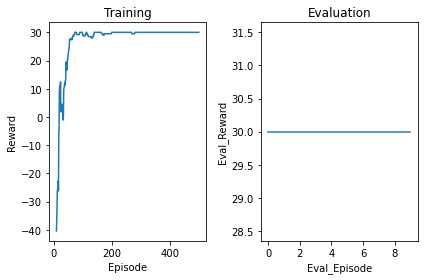

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt






hidden_size = 64
num_steps = 300
max_episodes = 500
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-3):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic1 = nn.Linear(num_inputs, hidden_size)
        self.critic2 = nn.Linear(hidden_size, 64)
        self.critic3 = nn.Linear(64, 1)

        self.actor1 = nn.Linear(num_inputs, hidden_size)
        self.actor2 = nn.Linear(hidden_size, 64)
        self.actor3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        v = F.relu(self.critic1(state))
        v = F.relu(self.critic2(v))
        v = self.critic3(v)
        
        policy_dist = F.relu(self.actor1(state))
        policy_dist = F.relu(self.actor2(policy_dist))
        policy_dist = F.softmax(self.actor3(policy_dist), dim=1)

        return v, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 12
    num_outputs = env.action_space.n
    
    actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     if T.cuda.is_available():
#         actor_critic.cuda()
    ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-3)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-3)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    train = True     
#     while train:
    for episode in range(max_episodes):
        if not train:
            break
        log_probs1 = []
        vs1 = []
#         log_probs2 = []
#         vs2 = []
        rewards = []
        done = False
        state = env.reset()
        print(episode)
        steps = 0
        # for steps in range(num_steps):
        while not done:
            v1, policy_dist1 = actor_critic1.forward(state)
            v1 = v1.detach().numpy()[0,0]
            dist1 = policy_dist1.detach().numpy()

#             v2, policy_dist2 = actor_critic2.forward(state)
#             v2 = v2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

            action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
            log_prob1 = T.log(policy_dist1.squeeze(0)[action1])
#             log_prob2 = T.log(policy_dist2.squeeze(0)[action2])
            entropy1 = -np.sum(np.mean(dist1) * np.log(dist1))
#             entropy2 = -np.sum(np.mean(dist2) * np.log(dist2))
            new_state, reward, done, goal = env.step(action1, deterministic = True)
#                 if goal:
#                     print('--------  Goal --------')
            rewards.append(reward)
            vs1.append(v1)
            log_probs1.append(log_prob1)
#             vs2.append(v2)
#             log_probs2.append(log_prob2)
            entropy_term1 += entropy1
#             entropy_term2 += entropy2
            state = new_state
            steps+=1

            # if done or steps == num_steps-1:
        print(f'took {steps} steps')
        Q1, _ = actor_critic1.forward(new_state)
#         Q2, _ = actor_critic2.forward(new_state)
#             print(type(Q))
        Q1 = Q1.detach().numpy()[0,0]
#         Q2 = Q2.detach().numpy()[0,0]
        all_rewards.append(np.sum(rewards))
#         print(np.sum(rewards))
        all_lengths.append(steps)
        average_lengths.append(np.mean(all_rewards[-10:]))
#             if episode % 10 == 0:                    
#                 print(f"episode: {episode}, reward: {np.sum(rewards)}, total length: {steps}, average length: {average_lengths[-1]} \n")
                # break
        if episode >= 60:
            if episode == max_episodes-1:
#                     print('Trained')
                train = False
        # compute Q vs
        Qs1 = np.zeros_like(vs1)
#         Qs2 = np.zeros_like(vs2)
        for t in reversed(range(len(rewards))):
            Q1 = rewards[t] + 0.99 * Q1
            Qs1[t] = Q1
#             Q2 = rewards[t] + 0.99 * Q2
#             Qs2[t] = Q2

        #update actor critic
        vs1 = T.FloatTensor(vs1)
        Qs1 = T.FloatTensor(Qs1)
        log_probs1 = T.stack(log_probs1)

        advantage1 = Qs1 - vs1
        actor_loss1 = (-log_probs1 * advantage1).mean()
        critic_loss1 = 0.5 * advantage1.pow(2).mean()
        ac_loss1 = actor_loss1 + critic_loss1# + 0.001 * entropy_term1

        ac_optimizer1.zero_grad()
        ac_loss1.backward()
        ac_optimizer1.step()

#         vs2 = T.FloatTensor(vs2)
#         Qs2 = T.FloatTensor(Qs2)
#         log_probs2 = T.stack(log_probs2)

#         advantage2 = Qs2 - vs2
#         actor_loss2 = (-log_probs2 * advantage2).mean()
#         critic_loss2 = 0.5 * advantage2.pow(2).mean()
#         ac_loss2 = actor_loss2 + critic_loss2# + 0.001 * entropy_term2

#         ac_optimizer2.zero_grad()
#         ac_loss2.backward()
#         ac_optimizer2.step()
    
            
    
        # Plot results
    avgd_r = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    avgd_r = [elem for elem in avgd_r]
    # plt.plot(all_rewards)
    plt.subplot(121)
    plt.plot(avgd_r)
#     plt.plot()
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
#     plt.show()
    
    eval_all_rewards = []
    for episode in range(eval_episodes):
        # eval_log_probs = []
        # eval_vs = []
        eval_rewards = []
        
        done = False
        state = env.reset()
#         print(type(state))
        steps = 0
        # for steps in range(num_steps):
        while not done:
            v1, policy_dist1 = actor_critic1.forward(state)
            v1 = v1.detach().numpy()[0,0]
            dist1 = policy_dist1.detach().numpy()

#             v2, policy_dist2 = actor_critic2.forward(state)
#             v2 = v2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

            action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
            # log_prob = T.log(policy_dist.squeeze(0)[action])
            # entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, goal = env.step(action1, deterministic = True)

            eval_rewards.append(reward)
            # eval_vs.append(v)
            # eval_log_probs.append(log_prob)
            # entropy_term += entropy
            state = new_state
            steps+=1
        eval_all_rewards.append(np.sum(eval_rewards))
    print(eval_all_rewards)
    # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
    # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
    # plt.plot(all_rewards)
    plt.subplot(122)
    plt.plot(eval_all_rewards)
#     plt.plot()
    plt.title('Evaluation')
    plt.xlabel('Eval_Episode')
    plt.ylabel('Eval_Reward')
    plt.tight_layout()
    plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()


if __name__ == "__main__":
    env = GridEnvironmentSingle()
    a2c(env) 

0
-----------------------------Goal1 Reached--------------------------------


+++++++++++++++Time Limit Reached++++++++++++++++++++++


took 100 no of steps
1
-----------------------------Goal2 Reached--------------------------------


-----------------------------Goal1 Reached--------------------------------


took 54 no of steps
2
-----------------------------Goal2 Reached--------------------------------


+++++++++++++++Time Limit Reached++++++++++++++++++++++


took 100 no of steps
3
-----------------------------Goal2 Reached--------------------------------


-----------------------------Goal1 Reached--------------------------------


took 27 no of steps
4
-----------------------------Goal2 Reached--------------------------------


+++++++++++++++Time Limit Reached++++++++++++++++++++++


took 100 no of steps
5
-----------------------------Goal2 Reached--------------------------------


-----------------------------Goal1 Reached--------------------------------


took 41 no of step

-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 25 no of steps
56
-----------------------------Goal2 Reached--------------------------------


-----------------------------Goal1 Reached--------------------------------


took 15 no of steps
57
-----------------------------Goal2 Reached--------------------------------


-----------------------------Goal1 Reached--------------------------------


took 16 no of steps
58
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 26 no of steps
59
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 20 no of steps
60
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Rea

-----------------------------Goal2 Reached--------------------------------


-----------------------------Goal1 Reached--------------------------------


took 11 no of steps
118
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 12 no of steps
119
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 13 no of steps
120
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 7 no of steps
121
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 17 no of steps
122
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2

-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 7 no of steps
187
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 7 no of steps
188
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
189
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 7 no of steps
190
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 10 no of steps
191
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Re

-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 8 no of steps
239
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 26 no of steps
240
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 8 no of steps
241
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 8 no of steps
242
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 7 no of steps
243
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Re

-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
313
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
314
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
315
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
316
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
317
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Rea

-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
380
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
381
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
382
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 8 no of steps
383
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
384
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
385
---------------

-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
452
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
453
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
454
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
455
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
456
-----------------------------Goal1 Reached--------------------------------


-----------------------------Goal2 Reached--------------------------------


took 6 no of steps
457
---------------

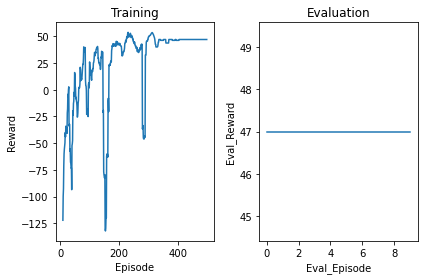

In [6]:
#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt






hidden_size = 64
num_steps = 300
max_episodes = 500
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-3):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 12
    num_outputs = env.action_space.n
    
    actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
    actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     if T.cuda.is_available():
#         actor_critic.cuda()
    ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-3)
    ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-3)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    train = True     
#     while train:
    for episode in range(max_episodes):
        if not train:
            break
        log_probs1 = []
        values1 = []
        log_probs2 = []
        values2 = []
        rewards = []
        done = False
        state = env.reset()
        print(episode)
        steps = 0
        # for steps in range(num_steps):
        while not done:
            value1, policy_dist1 = actor_critic1.forward(state)
            value1 = value1.detach().numpy()[0,0]
            dist1 = policy_dist1.detach().numpy()

            value2, policy_dist2 = actor_critic2.forward(state)
            value2 = value2.detach().numpy()[0,0]
            dist2 = policy_dist2.detach().numpy()

            action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
            action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
            log_prob1 = T.log(policy_dist1.squeeze(0)[action1])
            log_prob2 = T.log(policy_dist2.squeeze(0)[action2])
            entropy1 = -np.sum(np.mean(dist1) * np.log(dist1))
            entropy2 = -np.sum(np.mean(dist2) * np.log(dist2))
            new_state, reward, done, goal = env.step(action1, action2, deterministic = True)
#                 if goal:
#                     print('--------  Goal --------')
            rewards.append(reward)
            values1.append(value1)
            log_probs1.append(log_prob1)
            values2.append(value2)
            log_probs2.append(log_prob2)
            entropy_term1 += entropy1
            entropy_term2 += entropy2
            state = new_state
            steps+=1

            # if done or steps == num_steps-1:
        print(f'took {steps} no of steps')
        Qval1, _ = actor_critic1.forward(new_state)
        Qval2, _ = actor_critic2.forward(new_state)
#             print(type(Qval))
        Qval1 = Qval1.detach().numpy()[0,0]
        Qval2 = Qval2.detach().numpy()[0,0]
        all_rewards.append(np.sum(rewards))
#         print(np.sum(rewards))
        all_lengths.append(steps)
        average_lengths.append(np.mean(all_rewards[-10:]))
#             if episode % 10 == 0:                    
#                 print(f"episode: {episode}, reward: {np.sum(rewards)}, total length: {steps}, average length: {average_lengths[-1]} \n")
                # break
        if episode >= 60:
            if episode == max_episodes-1:
#                     print('Trained')
                train = False
        # compute Q values
        Qvals1 = np.zeros_like(values1)
        Qvals2 = np.zeros_like(values2)
        for t in reversed(range(len(rewards))):
            Qval1 = rewards[t] + 0.99 * Qval1
            Qvals1[t] = Qval1
            Qval2 = rewards[t] + 0.99 * Qval2
            Qvals2[t] = Qval2

        #update actor critic
        values1 = T.FloatTensor(values1)
        Qvals1 = T.FloatTensor(Qvals1)
        log_probs1 = T.stack(log_probs1)

        advantage1 = Qvals1 - values1
        actor_loss1 = (-log_probs1 * advantage1).mean()
        critic_loss1 = 0.5 * advantage1.pow(2).mean()
        ac_loss1 = actor_loss1 + critic_loss1 + 0.001 * entropy_term1

        ac_optimizer1.zero_grad()
        ac_loss1.backward()
        ac_optimizer1.step()

        values2 = T.FloatTensor(values2)
        Qvals2 = T.FloatTensor(Qvals2)
        log_probs2 = T.stack(log_probs2)

        advantage2 = Qvals2 - values2
        actor_loss2 = (-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 * entropy_term2

        ac_optimizer2.zero_grad()
        ac_loss2.backward()
        ac_optimizer2.step()
    
            
    
        # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    # plt.plot(all_rewards)
    plt.subplot(121)
    plt.plot(smoothed_rewards)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
#     plt.show()
    
    eval_all_rewards = []
    for episode in range(eval_episodes):
        # eval_log_probs = []
        # eval_values = []
        eval_rewards = []
        
        done = False
        state = env.reset()
#         print(type(state))
        steps = 0
        # for steps in range(num_steps):
        while not done:
            value1, policy_dist1 = actor_critic1.forward(state)
            value1 = value1.detach().numpy()[0,0]
            dist1 = policy_dist1.detach().numpy()

            value2, policy_dist2 = actor_critic2.forward(state)
            value2 = value2.detach().numpy()[0,0]
            dist2 = policy_dist2.detach().numpy()

            action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
            action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
            # log_prob = T.log(policy_dist.squeeze(0)[action])
            # entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

            eval_rewards.append(reward)
            # eval_values.append(value)
            # eval_log_probs.append(log_prob)
            # entropy_term += entropy
            state = new_state
            steps+=1
        eval_all_rewards.append(np.sum(eval_rewards))
    print(eval_all_rewards)
    # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
    # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
    # plt.plot(all_rewards)
    plt.subplot(122)
    plt.plot(eval_all_rewards)
    plt.title('Evaluation')
    plt.plot()
    plt.xlabel('Eval_Episode')
    plt.ylabel('Eval_Reward')
    plt.tight_layout()
    plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()


if __name__ == "__main__":
    env = GridEnvironmentM()
#     print(type(env.reset()))
    a2c(env) 

## MARL Pressure Plate Game

In [1]:
 
"""
2D rendering of the pressure plate domain
"""

import gym
from gym import spaces

from enum import IntEnum


import os
import sys

import numpy as np
import math
import six
from gym import error

if "Apple" in sys.version:
    if "DYLD_FALLBACK_LIBRARY_PATH" in os.environ:
        os.environ["DYLD_FALLBACK_LIBRARY_PATH"] += ":/usr/lib"
        # (JDS 2016/04/15): avoid bug on Anaconda 2.3.0 / Yosemite


try:
    import pyglet
except ImportError as e:
    raise ImportError(
        """
    Cannot import pyglet.
    HINT: you can install pyglet directly via 'pip install pyglet'.
    But if you really just want to install all Gym dependencies and not have to think about it,
    'pip install -e .[all]' or 'pip install gym[all]' will do it.
    """
    )

try:
    from pyglet.gl import *
except ImportError as e:
    raise ImportError(
        """
    Error occured while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s \"-screen 0 1400x900x24\" python <your_script.py>'
    """
    )


RAD2DEG = 57.29577951308232
# # Define some colors
_BLACK = (0, 0, 0)
_WHITE = (255, 255, 255)
_GREEN = (0, 255, 0)
_RED = (255, 0, 0)


def get_display(spec):
    """Convert a display specification (such as :0) into an actual Display
    object.
    Pyglet only supports multiple Displays on Linux.
    """
    if spec is None:
        return None
    elif isinstance(spec, six.string_types):
        return pyglet.canvas.Display(spec)
    else:
        raise error.Error(
            "Invalid display specification: {}. (Must be a string like :0 or None.)".format(
                spec
            )
        )


class Viewer:
    def __init__(self, world_size):
        display = get_display(None)

        # Let's have the display auto-scale to a 500x500 window
        self.rows, self.cols = world_size

        self.grid_size = 800 / self.rows
        self.icon_size = 20

        self.width = self.cols * self.grid_size + 1
        self.height = self.rows * self.grid_size + 1

        disp_height = 800
        disp_width = 800 * (self.cols / self.rows)

        self.window = pyglet.window.Window(
            width=int(disp_width), height=disp_height, display=display
        )

        self.window.on_close = self.window_closed_by_user
        self.isopen = True

        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)

        script_dir = 'C:\\Users\\sabdu\\Downloads\\try\\pressureplate\\pressureplate\\'

        pyglet.resource.path = [os.path.join(script_dir, "icons")]
        pyglet.resource.reindex()

        # self.img_apple = pyglet.resource.image("apple.png")
        self.img_agent = pyglet.resource.image("agent.png")
        self.img_wall = pyglet.resource.image('brick-wall.png')
        self.img_door = pyglet.resource.image('spiked-fence.png')
        # self.img_door_left = pyglet.resource.image('doorway_left.png')
        # self.img_door_right = pyglet.resource.image('doorway_right.png')
        self.img_plate_off = pyglet.resource.image('plate_off.png')
        self.img_plate_on = pyglet.resource.image('plate_on.png')
        self.goal = pyglet.resource.image('chest.png')
        self.goal_open = pyglet.resource.image('open-treasure-chest.png')

    def close(self):
        self.window.close()
        
    def window_closed_by_user(self):
        self.isopen = False
        exit()

    def set_bounds(self, left, right, bottom, top):
        assert right > left and top > bottom
        scalex = self.width / (right - left)
        scaley = self.height / (top - bottom)
        self.transform = Transform(
            translation=(-left * scalex, -bottom * scaley), scale=(scalex, scaley)
        )

    def render(self, env, return_rgb_array=False):
        glClearColor(0.65, 0.65, 0.65, 0.65)
        self.window.clear()
        self.window.switch_to()
        self.window.dispatch_events()

        # TODO: CHANGE
        self._draw_grid()

        self._draw_walls(env)
        self._draw_doors(env)
        self._draw_plates(env)
        self._draw_goal(env)
        self._draw_players(env)
        self._draw_badges(env)

        if return_rgb_array:
            buffer = pyglet.image.get_buffer_manager().get_color_buffer()
            image_data = buffer.get_image_data()
            arr = np.frombuffer(image_data.get_data(), dtype=np.uint8)
            arr = arr.reshape(buffer.height, buffer.width, 4)
            arr = arr[::-1, :, 0:3]
        self.window.flip()
        return arr if return_rgb_array else self.isopen

    def _draw_grid(self):
        batch = pyglet.graphics.Batch()
        for r in range(self.rows + 1):
            batch.add(
                2,
                gl.GL_LINES,
                None,
                (
                    "v2f",
                    (
                        0,
                        self.grid_size * r,
                        self.grid_size * self.cols,
                        self.grid_size * r,
                    ),
                ),
                ("c3B", (*_BLACK, *_BLACK)),
            )
        for c in range(self.cols + 1):
            batch.add(
                2,
                gl.GL_LINES,
                None,
                (
                    "v2f",
                    (
                        self.grid_size * c,
                        0,
                        self.grid_size * c,
                        self.grid_size * self.rows,
                    ),
                ),
                ("c3B", (*_BLACK, *_BLACK)),
            )
        batch.draw()

    def _draw_players(self, env):
        players = []
        batch = pyglet.graphics.Batch()

        for player in env.agents:
            row, col = player.y, player.x
            players.append(
                pyglet.sprite.Sprite(
                    self.img_agent,
                    self.grid_size * col,
                    self.height - self.grid_size * (row + 1),
                    batch=batch,
                )
            )
        for p in players:
            p.update(scale=self.grid_size / p.width)
        batch.draw()
        # for p in env.agents:
        #     self._draw_badge(*(p.x, p.y), p.level)

    def _draw_walls(self, env):
        walls = []
        batch = pyglet.graphics.Batch()

        for wall in env.walls:
            row, col = wall.y, wall.x
            walls.append(
                pyglet.sprite.Sprite(
                    self.img_wall,
                    self.grid_size * col,
                    self.height - self.grid_size * (row + 1),
                    batch=batch
                )
            )

        for w in walls:
            w.update(scale=self.grid_size / w.width)
        batch.draw()

    def _draw_doors(self, env):
        doors = []
        batch = pyglet.graphics.Batch()

        for door in env.doors:
            for j in range(len(door.x)):
                row, col = door.y[j], door.x[j]

                # if not len(door.x) > 1:
                if not door.open:
                    doors.append(
                        pyglet.sprite.Sprite(
                            self.img_door,
                            self.grid_size * col,
                            self.height - self.grid_size * (row + 1),
                            batch=batch
                        )
                    )

        for d in doors:
            d.update(scale=self.grid_size / d.width)
        batch.draw()

    def _draw_plates(self, env):
        plates = []
        batch = pyglet.graphics.Batch()

        for plate in env.plates:
            row, col = plate.y, plate.x

            if plate.pressed:
                plates.append(
                    pyglet.sprite.Sprite(
                        self.img_plate_on,
                        self.grid_size * col,
                        self.height - self.grid_size * (row + 1),
                        batch=batch
                    )
                )
            else:
                plates.append(
                    pyglet.sprite.Sprite(
                        self.img_plate_off,
                        self.grid_size * col,
                        self.height - self.grid_size * (row + 1),
                        batch=batch
                    )
                )

        for p in plates:
            p.update(scale=self.grid_size / p.width)
        batch.draw()

    def _draw_goal(self, env):
        goals = []
        batch = pyglet.graphics.Batch()

        row, col = env.goal.y, env.goal.x

        if env.goal.achieved:
            goals.append(
                pyglet.sprite.Sprite(
                    self.goal_open,
                    self.grid_size * col,
                    self.height - self.grid_size * (row + 1),
                    batch=batch
                )
            )
        else:
            goals.append(
                pyglet.sprite.Sprite(
                    self.goal,
                    self.grid_size * col,
                    self.height - self.grid_size * (row + 1),
                    batch=batch
                )
            )

        for g in goals:
            g.update(scale=self.grid_size / g.width)
        batch.draw()

    def _draw_badges(self, env):
        # Agents
        for agent in env.agents:
            self._draw_badge(agent.y, agent.x, agent.id)

        # Plates
        for plate in env.plates:
            if not plate.pressed:
                self._draw_badge(plate.y, plate.x, plate.id)

        # Doors
        for door in env.doors:
            if not door.open:
                for j in range(len(door.x)):
                    self._draw_badge(door.y[j], door.x[j], door.id)

    def _draw_badge(self, row, col, id):
        resolution = 6
        radius = self.grid_size / 5

        badge_x = col * self.grid_size + (3 / 4) * self.grid_size
        badge_y = self.height - self.grid_size * (row + 1) + (1 / 4) * self.grid_size

        # make a circle
        verts = []
        for i in range(resolution):
            angle = 2 * math.pi * i / resolution
            x = radius * math.cos(angle) + badge_x
            y = radius * math.sin(angle) + badge_y
            verts += [x, y]
        circle = pyglet.graphics.vertex_list(resolution, ("v2f", verts))
        glColor3ub(*_BLACK)
        circle.draw(GL_POLYGON)
        glColor3ub(*_WHITE)
        circle.draw(GL_LINE_LOOP)
        label = pyglet.text.Label(
            str(id),
            font_name="Times New Roman",
            font_size=12,
            x=badge_x,
            y=badge_y + 2,
            anchor_x="center",
            anchor_y="center",
        )
        label.draw()
        

   
"""
	For ease of use, please lay out your grid in Euclidean-plane format and NOT
	in numpy-type format. For example, if an object needs to be placed in the
	3rd row and 7th column of the gridworld numpy matrix, enter its location in your
	layout dict as [7,3]. The codebase will take care of the matrix-indexing for you.
	For example, the above object will be queried as grid[3, 7] when placed into the
	grid.
	NOTE: the origin (0,0) is the top-left corner of the grid. The positive direction
	along the x-axis counts to the right and the positive direction along the y-axis
"""

LINEAR = {
    
	'TWO_PLAYERS': {
		'WALLS': [
			# Third wall
			[0, 3],
			[1, 3],
			[2, 3],
			[5, 3]

		],

		# Doors are double doors of coord [[x1,x2], [y1,y2]]
		'DOORS': [
			[[3, 4], [3, 3]]
		],

		'PLATES': [
			[4, 5]
		],

		'AGENTS': [
			[2, 5],
			[2, 4]
		],

		'GOAL': [
			[3, 1]
		]
	},

	'THREE_PLAYERS': {
		'WALLS': [
            # Second wall
            [0, 3],
            [3, 3],
            [4, 3],
            [5, 3],
            # First wall
            [0, 7],
            [1, 7],
            [2, 7],
            [5, 7]
            

		],

		# Doors are double doors of coord [[x1,x2], [y1,y2]]
		'DOORS': [
			[[3, 4], [7, 7]],
            [[1, 2], [3, 3]]
            
		],

		'PLATES': [
			[4, 9],
            [5, 4]
		],

		'AGENTS': [
			[2, 9],
			[2, 8],
            [1, 8]
		],

		'GOAL': [
			[2, 0]
		]
	},
    
	'FOUR_PLAYERS': {
		'WALLS': [
			# First wall
			[0, 11],
			[1, 11],
			[2, 11],
			[3, 11],
			[4, 11],
			[5, 11],
			[8, 11],

			# Second wall
			[0, 7],
			[1, 7],
			[4, 7],
			[5, 7],
			[6, 7],
			[7, 7],
			[8, 7],

			# Third wall
			[0, 3],
			[1, 3],
			[2, 3],
			[3, 3],
			[4, 3],
			[5, 3],
			[8, 3]

		],

		# Doors are double doors of coord [[x1,x2], [y1,y2]]
		'DOORS': [
			[[6, 7], [11, 11]],
			[[2, 3], [7, 7]],
			[[6, 7], [3, 3]]
		],

		'PLATES': [
			[7, 13],
			[2, 9],
			[7, 5]
		],

		'AGENTS': [
			[5, 13],
			[5, 12],
			[4, 13],
			[4, 12]
		],

		'GOAL': [
			[3, 1]
		]
	},
	'FIVE_PLAYERS': {
		'WALLS': [
			# First wall
			[0, 15],
			[1, 15],
			# [4, 15],
			[5, 15],
			[6, 15],
			[7, 15],
			[8, 15],

			# Second wall
			[0, 11],
			[1, 11],
			[2, 11],
			[3, 11],
			[4, 11],
			# [5, 11],
			[8, 11],

			# Third wall
			[0, 7],
			[1, 7],
			# [4, 7],
			[5, 7],
			[6, 7],
			[7, 7],
			[8, 7],

			# Fourth wall
			[0, 3],
			[1, 3],
			[2, 3],
			[3, 3],
			[4, 3],
			# [5, 3],
			[8, 3],
		],

		# Doors are double doors of coord [[x1,x2], [y1,y2]]
		'DOORS': [
			[[2, 3, 4], [15, 15, 15]],
			[[5, 6, 7], [11, 11, 11]],
			[[2, 3, 4], [7, 7, 7]],
			[[5, 6, 7], [3, 3, 3]]
		],

		'PLATES': [
			[2, 17],
			[7, 13],
			[2, 9],
			[7, 5]
		],

		'AGENTS': [
			[6, 16],
			[5, 17],
			[5, 16],
			[4, 17],
			[4, 16]
		],

		'GOAL': [
			[3, 1]
		]
	},

	'SIX_PLAYERS': {
		'WALLS': [
			# First wall
			[0, 19],
			[1, 19],
			[2, 19],
			[3, 19],
			[4, 19],
			# [5, 19],
			[8, 19],

			# Second wall
			[0, 15],
			[1, 15],
			# [4, 15],
			[5, 15],
			[6, 15],
			[7, 15],
			[8, 15],

			# Third wall
			[0, 11],
			[1, 11],
			[2, 11],
			[3, 11],
			[4, 11],
			# [5, 11],
			[8, 11],

			# Fourth wall
			[0, 7],
			[1, 7],
			# [4, 7],
			[5, 7],
			[6, 7],
			[7, 7],
			[8, 7],

			# Fifth wall
			[0, 3],
			[1, 3],
			[2, 3],
			[3, 3],
			[4, 3],
			# [5, 3],
			[8, 3],
		],

		# Doors are double doors of coord [[x1,x2], [y1,y2]]
		'DOORS': [
			[[5, 6, 7], [19, 19, 19]],
			[[2, 3, 4], [15, 15, 15]],
			[[5, 6, 7], [11, 11, 11]],
			[[2, 3, 4], [7, 7, 7]],
			[[5, 6, 7], [3, 3, 3]]
		],

		'PLATES': [
			[7, 21],
			[2, 17],
			[7, 13],
			[2, 9],
			[7, 5]
		],

		'AGENTS': [
			[6, 21],
			[6, 20],
			[5, 21],
			[5, 20],
			[4, 21],
			[4, 20]
		],

		'GOAL': [
			[3, 1]
		]
	}
}

  



# Global elements
_LAYER_AGENTS = 0
_LAYER_WALLS = 1
_LAYER_DOORS = 2
_LAYER_PLATES = 3
_LAYER_GOAL = 4


class Actions(IntEnum):
    Up = 0
    Down = 1
    Left = 2
    Right = 3
    Noop = 4


class Entity:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y


class Agent(Entity):
    def __init__(self, id, x, y):
        super().__init__(id, x, y)


class Plate(Entity):
    def __init__(self, id, x, y):
        super().__init__(id, x, y)
        self.pressed = False


class Door(Entity):
    def __init__(self, id, x, y):
        super().__init__(id, x, y)
        self.open = False


class Wall(Entity):
    def __init__(self, id, x, y):
        super().__init__(id, x, y)


class Goal(Entity):
    def __init__(self, id, x, y):
        super().__init__(id, x, y)
        self.achieved = False


class PressurePlate(gym.Env):
    """"""
    metadata = {"render.modes": ["human"]}

    def __init__(self, height, width, n_agents, sensor_range, layout):
        self.grid_size = (height, width)
        self.n_agents = n_agents
        self.sensor_range = sensor_range

        self.grid = np.zeros((5, *self.grid_size))

        self.action_space = spaces.Tuple(tuple(n_agents * [spaces.Discrete(len(Actions))]))

        self.action_space_dim = (sensor_range + 1) * (sensor_range + 1) * 4 + 2

        self.observation_space = spaces.Tuple(tuple(
            n_agents * [spaces.Box(np.array([0] * self.action_space_dim), np.array([1] * self.action_space_dim))]
        ))
        self.agents = []
        self.plates = []
        self.walls = []
        self.doors = []
        self.goal = None

        self._rendering_initialized = False

        if layout == 'linear':
            if self.n_agents == 2:
                self.layout = LINEAR['TWO_PLAYERS']
            
            elif self.n_agents == 3:
                self.layout = LINEAR['THREE_PLAYERS']
            
            elif self.n_agents == 4:
                self.layout = LINEAR['FOUR_PLAYERS']

            elif self.n_agents == 5:
                self.layout = LINEAR['FIVE_PLAYERS']

            elif self.n_agents == 6:
                self.layout = LINEAR['SIX_PLAYERS']
            else:
                raise ValueError(f'Number of agents given ({self.n_agents}) is not supported.')

        self.max_dist = np.linalg.norm(np.array([0, 0]) - np.array([2, 8]), 1)
        self.agent_order = list(range(n_agents))
        self.viewer = None

        self.room_boundaries = np.unique(np.array(self.layout['WALLS'])[:, 1]).tolist()[::-1]
        self.room_boundaries.append(-1)
        print(self.room_boundaries)

    def step(self, actions,steps):
        """obs, reward, done info"""
#         np.random.shuffle(self.agent_order)
        rewards =[0]*self.n_agents
        for i in range(self.n_agents):
            proposed_pos = [self.agents[i].x, self.agents[i].y]

            if actions[i] == 0:
                proposed_pos[1] -= 1
                collision,r = self._detect_collision(proposed_pos,i,False)
                if not collision:
                    self.agents[i].y -= 1
                    rewards[i]-=0.5
#                     if steps> 290:
#                         print(f'Agent{i+1} moved UP to {self.agents[i].x, self.agents[i].y}')
                else:
                    rewards[i]+=r

            elif actions[i] == 1:
                proposed_pos[1] += 1
                collision,r = self._detect_collision(proposed_pos,i,True)
                if not collision:
                    self.agents[i].y += 1
                    rewards[i]-=0.5
#                     if steps> 290:
#                         print(f'Agent{i+1} moved DOWN to {self.agents[i].x, self.agents[i].y}')
                else:
                    rewards[i]+=r
                    
                    

            elif actions[i] == 2:
                proposed_pos[0] -= 1
                collision,r = self._detect_collision(proposed_pos,i,False)
                if not collision:
                    self.agents[i].x -= 1
                    rewards[i]-=0.5
#                     if steps> 290:
#                         print(f'Agent{i+1} moved LEFT to {self.agents[i].x, self.agents[i].y}')
                else:
                    rewards[i]+=r

            elif actions[i] == 3:
                proposed_pos[0] += 1
                collision,r = self._detect_collision(proposed_pos,i,False)
                if not collision:
                    self.agents[i].x += 1
                    rewards[i]-=0.5
#                     if steps> 290:
#                         print(f'Agent{i+1} moved RIGHT to {self.agents[i].x, self.agents[i].y}')
                else:
                    rewards[i]+=r

            else:
                # NOOP
                
                if i < len(self.plates):
                    if self.plates[i].pressed:
                        rewards[i]+=2000
#                     if steps> 290:
#                         print(f'Agent{i} stayed on PLATE at {self.agents[i].x, self.agents[i].y}')
                    else:
                        rewards[i]-=0.5
#                     if steps> 290:
#                             print(f'Agent{i+1} stayed at {self.agents[i].x, self.agents[i].y}')
                else:
                    rewards[i]-=5
#                     if steps> 290:
#                         print(f'Agent{i+1} stayed at {self.agents[i].x, self.agents[i].y}')
                
                

        for i, plate in enumerate(self.plates):
            if not plate.pressed:
                if [plate.x, plate.y] == [self.agents[plate.id].x, self.agents[plate.id].y]:
                    plate.pressed = True
                    self.doors[plate.id].open = True
                    rewards[plate.id] += 2000
#                     if steps> 290:
#                     print(f'Agent{i} stepped ON PLATE{plate.id} at {self.agents[i].x, self.agents[i].y}')

            else:
                if [plate.x, plate.y] != [self.agents[plate.id].x, self.agents[plate.id].y]:
                    plate.pressed = False
                    self.doors[plate.id].open = False
                    rewards[plate.id] -= 100
#                     if steps> 290:
#                     print(f'Agent{i} stepped OFF PLATE at {self.agents[i].x, self.agents[i].y}')

        # Detecting goal completion
        r = []
        for agent in self.agents:
            r.append([agent.x, agent.y] == [self.goal.x, self.goal.y])
        got_goal = np.sum(r) > 0

        if got_goal:
            self.goal.achieved = True
            rewards[self.goal.id] += 10000
            print(f'Agent reached GOAL')
        rewards = np.array(rewards,dtype ='float64')
        rewards += np.array(self._get_rewards())

        return self._get_obs(), rewards, [self.goal.achieved] * self.n_agents, {}

    def _detect_collision(self, proposed_position,i,back):
        """Need to check for collision with (1) grid edge, (2) walls, (3) closed doors (4) other agents"""
        # Grid edge
        r = 0
        if np.any([
            proposed_position[0] < 0,
            proposed_position[1] < 0,
            proposed_position[0] >= self.grid_size[1],
            proposed_position[1] >= self.grid_size[0]
        ]):
#             print(f'Agent{i+1} Collided Boundary')
            r-=50
            return True,r

        # Walls
        for wall in self.walls:
            if proposed_position == [wall.x, wall.y]:
#                 print(f'Agent{i+1} Collided Wall')
                r-=5
                return True,r

        # Closed Door
        for door in self.doors:
            if not door.open:
                for j in range(len(door.x)):
                    if proposed_position == [door.x[j], door.y[j]]:
                        if i == door.id+1 and not back:
                            r += 50
#                             print(f'Agent{i} Collided Door{door.id}')
                        else:
                            r -= 50
                        return True,r
            elif door.open and back and i != door.id:
                r -= 50
                return True,r
                

        # Other agents
        for agent in self.agents:
            if proposed_position == [agent.x, agent.y]:
#                 r-=2
#                 print(f'Agent{i+1} Collided with another agent')
                return True,r

        return False,r

    def reset(self):
        # Grid wipe
        self.grid = np.zeros((5, *self.grid_size))

        # Agents
        self.agents = []
        for i in range(self.n_agents):
            self.agents.append(Agent(i,
                                    self.layout['AGENTS'][self.agent_order[i]][0],
                                    self.layout['AGENTS'][self.agent_order[i]][1]))
            self.grid[_LAYER_AGENTS,
                    self.layout['AGENTS'][self.agent_order[i]][1],
                    self.layout['AGENTS'][self.agent_order[i]][0]] = 1

        # Walls
        self.walls = []
        for i, wall in enumerate(self.layout['WALLS']):
            self.walls.append(Wall(i, wall[0], wall[1]))
            self.grid[_LAYER_WALLS, wall[1], wall[0]] = 1

        # Doors
        self.doors = []
        for i, door in enumerate(self.layout['DOORS']):
            self.doors.append(Door(i, door[0], door[1]))
            for j in range(len(door[0])):
                self.grid[_LAYER_DOORS, door[1][j], door[0][j]] = 1

        # Plate
        self.plates = []
        for i, plate in enumerate(self.layout['PLATES']):
            self.plates.append(Plate(i, plate[0], plate[1]))
            self.grid[_LAYER_PLATES, plate[1], plate[0]] = 1

        # Goal
        self.goal = []
        self.goal = Goal(self.n_agents - 1, self.layout['GOAL'][0][0], self.layout['GOAL'][0][1])
        self.grid[_LAYER_GOAL, self.layout['GOAL'][0][1], self.layout['GOAL'][0][0]] = 1

        return self._get_obs()

    def _get_obs(self):
        obs = []

        for agent in self.agents:
            x, y = agent.x, agent.y
            pad = self.sensor_range // 2

            x_left = max(0, x - pad)
            x_right = min(self.grid_size[1] - 1, x + pad)
            y_up = max(0, y - pad)
            y_down = min(self.grid_size[0] - 1, y + pad)

            x_left_padding = pad - (x - x_left)
            x_right_padding = pad - (x_right - x)
            y_up_padding = pad - (y - y_up)
            y_down_padding = pad - (y_down - y)

            # When the agent's vision, as defined by self.sensor_range, goes off of the grid, we
            # pad the grid-version of the observation. For all objects but walls, we pad with zeros.
            # For walls, we pad with ones, as edges of the grid act in the same way as walls.
            # For padding, we follow a simple pattern: pad left, pad right, pad up, pad down
            # Agents
            _agents = self.grid[_LAYER_AGENTS, y_up:y_down + 1, x_left:x_right + 1]

            _agents = np.concatenate((np.zeros((_agents.shape[0], x_left_padding)), _agents), axis=1)
            _agents = np.concatenate((_agents, np.zeros((_agents.shape[0], x_right_padding))), axis=1)
            _agents = np.concatenate((np.zeros((y_up_padding, _agents.shape[1])), _agents), axis=0)
            _agents = np.concatenate((_agents, np.zeros((y_down_padding, _agents.shape[1]))), axis=0)
            _agents = _agents.reshape(-1)

            # Walls
            _walls = self.grid[_LAYER_WALLS, y_up:y_down + 1, x_left:x_right + 1]

            _walls = np.concatenate((np.ones((_walls.shape[0], x_left_padding)), _walls), axis=1)
            _walls = np.concatenate((_walls, np.ones((_walls.shape[0], x_right_padding))), axis=1)
            _walls = np.concatenate((np.ones((y_up_padding, _walls.shape[1])), _walls), axis=0)
            _walls = np.concatenate((_walls, np.ones((y_down_padding, _walls.shape[1]))), axis=0)
            _walls = _walls.reshape(-1)

            # Doors
            _doors = self.grid[_LAYER_DOORS, y_up:y_down + 1, x_left:x_right + 1]

            _doors = np.concatenate((np.zeros((_doors.shape[0], x_left_padding)), _doors), axis=1)
            _doors = np.concatenate((_doors, np.zeros((_doors.shape[0], x_right_padding))), axis=1)
            _doors = np.concatenate((np.zeros((y_up_padding, _doors.shape[1])), _doors), axis=0)
            _doors = np.concatenate((_doors, np.zeros((y_down_padding, _doors.shape[1]))), axis=0)
            _doors = _doors.reshape(-1)

            # Plate
            _plates = self.grid[_LAYER_PLATES, y_up:y_down + 1, x_left:x_right + 1]

            _plates = np.concatenate((np.zeros((_plates.shape[0], x_left_padding)), _plates), axis=1)
            _plates = np.concatenate((_plates, np.zeros((_plates.shape[0], x_right_padding))), axis=1)
            _plates = np.concatenate((np.zeros((y_up_padding, _plates.shape[1])), _plates), axis=0)
            _plates = np.concatenate((_plates, np.zeros((y_down_padding, _plates.shape[1]))), axis=0)
            _plates = _plates.reshape(-1)

            # Goal
            _goal = self.grid[_LAYER_GOAL, y_up:y_down + 1, x_left:x_right + 1]

            _goal = np.concatenate((np.zeros((_goal.shape[0], x_left_padding)), _goal), axis=1)
            _goal = np.concatenate((_goal, np.zeros((_goal.shape[0], x_right_padding))), axis=1)
            _goal = np.concatenate((np.zeros((y_up_padding, _goal.shape[1])), _goal), axis=0)
            _goal = np.concatenate((_goal, np.zeros((y_down_padding, _goal.shape[1]))), axis=0)
            _goal = _goal.reshape(-1)

            # Concat
            obs.append(np.concatenate((_agents, _plates, _doors, _goal, np.array([x, y])), axis=0, dtype=np.float32))

        return tuple(obs)

    def _get_flat_grid(self):
        grid = np.zeros(self.grid_size)

        # Plate
        for plate in self.plates:
            grid[plate.y, plate.x] = 2

        # Walls
        for wall in self.walls:
            grid[wall.y, wall.x] = 3

        # Doors
        for door in self.doors:
            if door.open:
                grid[door.y, door.x] = 0
            else:
                grid[door.y, door.x] = 4

        # Goal
        grid[self.goal.y, self.goal.x] = 5

        # Agents
        for agent in self.agents:
            grid[agent.y, agent.x] = 1

        return grid

    def _get_rewards(self):
        rewards = []

        # The last agent's desired location is the goal instead of a plate, so we use an if/else block
        # to break between the two cases
        for i, agent in enumerate(self.agents):

            if i == len(self.agents) - 1:
                plate_loc = self.goal.x, self.goal.y
            else:
                plate_loc = self.plates[i].x, self.plates[i].y

#             curr_room = self._get_curr_room_reward(agent.y)

            agent_loc = agent.x, agent.y

#             if i == curr_room:
            reward = - np.linalg.norm((np.array(plate_loc) - np.array(agent_loc)), 1)/2
#             print(f'agent{i} default rew {reward/self.max_dist } else {reward} for same room at {agent.x,agent.y}')
#                 / self.max_dist
#             else:
#                 reward = - len(self.room_boundaries)+1 + curr_room
#                 print(f'for diff room agent{i} {reward} at {agent.x,agent.y}')
            
            rewards.append(reward)
        return rewards

    def _get_curr_room_reward(self, agent_y):
        for i, room_level in enumerate(self.room_boundaries):
            if agent_y > room_level:
                curr_room = i
                break

        return curr_room

    def _init_render(self):
#         from .rendering import Viewer
        self.viewer = Viewer(self.grid_size)
        self._rendering_initialized = True

    def render(self, mode='human'):
        if not self._rendering_initialized:
            self._init_render()
        return self.viewer.render(self, mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()


## 2 Players

[3, -1]
0
Agent reached GOAL
Goal reached
took 310 no of steps
1
took 500 no of steps
2
took 500 no of steps
3
Agent reached GOAL
Goal reached
took 347 no of steps
4
Agent reached GOAL
Goal reached
took 80 no of steps
5
Agent reached GOAL
Goal reached
took 38 no of steps
6
Agent reached GOAL
Goal reached
took 314 no of steps
7
Agent reached GOAL
Goal reached
took 224 no of steps
8
Agent reached GOAL
Goal reached
took 267 no of steps
9
Agent reached GOAL
Goal reached
took 268 no of steps
10
Agent reached GOAL
Goal reached
took 142 no of steps
11
Agent reached GOAL
Goal reached
took 330 no of steps
12
Agent reached GOAL
Goal reached
took 158 no of steps
13
Agent reached GOAL
Goal reached
took 101 no of steps
14
took 500 no of steps
15
Agent reached GOAL
Goal reached
took 397 no of steps
16
Agent reached GOAL
Goal reached
took 28 no of steps
17
Agent reached GOAL
Goal reached
took 190 no of steps
18
Agent reached GOAL
Goal reached
took 22 no of steps
19
Agent reached GOAL
Goal reached
too

Goal reached
took 5 no of steps
164
Agent reached GOAL
Goal reached
took 5 no of steps
165
Agent reached GOAL
Goal reached
took 5 no of steps
166
Agent reached GOAL
Goal reached
took 5 no of steps
167
Agent reached GOAL
Goal reached
took 5 no of steps
168
Agent reached GOAL
Goal reached
took 5 no of steps
169
Agent reached GOAL
Goal reached
took 5 no of steps
170
Agent reached GOAL
Goal reached
took 5 no of steps
171
Agent reached GOAL
Goal reached
took 5 no of steps
172
Agent reached GOAL
Goal reached
took 5 no of steps
173
Agent reached GOAL
Goal reached
took 5 no of steps
174
Agent reached GOAL
Goal reached
took 5 no of steps
175
Agent reached GOAL
Goal reached
took 5 no of steps
176
Agent reached GOAL
Goal reached
took 5 no of steps
177
Agent reached GOAL
Goal reached
took 5 no of steps
178
Agent reached GOAL
Goal reached
took 5 no of steps
179
Agent reached GOAL
Goal reached
took 5 no of steps
180
Agent reached GOAL
Goal reached
took 5 no of steps
181
Agent reached GOAL
Goal reach

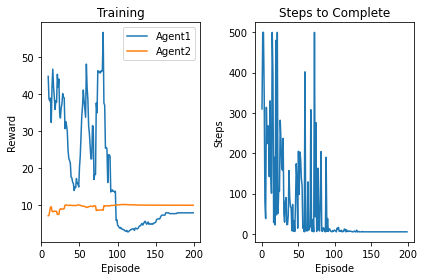

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 500
max_episodes = 200
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-3):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    
    actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
    actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     if T.cuda.is_available():
#         actor_critic.cuda()
    ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-3)
    ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-3)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    train = True     
    step_progression = []
    env.reset()
    env.render()
#     sleep(20)
#     env.viewer.close()
#     while train:
    for episode in range(max_episodes):
        if not train:
            break
        log_probs1 = []
        values1 = []
        log_probs2 = []
        values2 = []
        rewards = []
        done = False
        state = env.reset()
        print(episode)
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals != 2 and steps< num_steps:
            value1, policy_dist1 = actor_critic1.forward(state[0])
            value1 = value1.detach().numpy()[0,0]
            dist1 = policy_dist1.detach().numpy()

            value2, policy_dist2 = actor_critic2.forward(state[1])
            value2 = value2.detach().numpy()[0,0]
            dist2 = policy_dist2.detach().numpy()

            action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
            action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
            log_prob1 = T.log(policy_dist1.squeeze(0)[action1])
            log_prob2 = T.log(policy_dist2.squeeze(0)[action2])
            entropy1 = -np.sum(np.mean(dist1) * np.log(dist1))
            entropy2 = -np.sum(np.mean(dist2) * np.log(dist2))
            new_state, reward, done, _ = env.step([action1, action2],steps)
#             print(reward)
            if np.sum(done)>1:
                print('Goal reached')
            goals = np.sum(done)
            rewards.append(reward)
            values1.append(value1)
            log_probs1.append(log_prob1)
            values2.append(value2)
            log_probs2.append(log_prob2)
            entropy_term1 += entropy1
            entropy_term2 += entropy2
            state = new_state
            steps+=1
#             env.render()
#             sleep(0.2)
            
#         env.render()
#         sleep(0.5)
            # if done or steps == num_steps-1:
        print(f'took {steps} no of steps')
        step_progression.append(steps)
        Qval1, _ = actor_critic1.forward(new_state[0])
        Qval2, _ = actor_critic2.forward(new_state[1])
#             print(type(Qval))
        Qval1 = Qval1.detach().numpy()[0,0]
        Qval2 = Qval2.detach().numpy()[0,0]
        all_rewards.append(np.sum(rewards, axis = 0))
#         print(rewards)
#         print(all_rewards)
#         print(np.sum(rewards))
        all_lengths.append(steps)
#         average_lengths.append(np.mean(all_rewards[-10:]))
#             if episode % 10 == 0:                    
#                 print(f"episode: {episode}, reward: {np.sum(rewards)}, total length: {steps}, average length: {average_lengths[-1]} \n")
                # break
#         if episode >= 60:
#             if episode == max_episodes-1:
# #                     print('Trained')
#                 train = False
        # compute Q values
        Qvals1 = np.zeros_like(values1)
        Qvals2 = np.zeros_like(values2)
        for t in reversed(range(len(rewards))):
            Qval1 = rewards[t][0] + 0.99 * Qval1
            Qvals1[t] = Qval1
            Qval2 = rewards[t][1] + 0.99 * Qval2
            Qvals2[t] = Qval2

        #update actor critic
        values1 = T.FloatTensor(values1)
        Qvals1 = T.FloatTensor(Qvals1)
        log_probs1 = T.stack(log_probs1)

        advantage1 = Qvals1 - values1
        actor_loss1 = (-log_probs1 * advantage1).mean()
        critic_loss1 = 0.5 * advantage1.pow(2).mean()
        ac_loss1 = actor_loss1 + critic_loss1 + 0.001 * entropy_term1

        ac_optimizer1.zero_grad()
        ac_loss1.backward()
        ac_optimizer1.step()

        values2 = T.FloatTensor(values2)
        Qvals2 = T.FloatTensor(Qvals2)
        log_probs2 = T.stack(log_probs2)

        advantage2 = Qvals2 - values2
        actor_loss2 = (-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 * entropy_term2

        ac_optimizer2.zero_grad()
        ac_loss2.backward()
        ac_optimizer2.step()
    
            
    
        # Plot results
    r1 = []
    r2 = []
#     print(all_rewards)
    for i in all_rewards:
#         print(i[1])
        r1.append(i[0]/1000)
        r2.append(i[1]/1000)
    smoothed_rewards1 = pd.Series.rolling(pd.Series(r1), 10).mean()
    smoothed_rewards2 = pd.Series.rolling(pd.Series(r2), 10).mean()
    smoothed_rewards1 = [elem for elem in smoothed_rewards1]
    smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    print(r1,r2)
    # plt.plot(all_rewards)
    plt.subplot(121)
    plt.plot(smoothed_rewards1,label = 'Agent1')
    plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.subplot(122)
    plt.plot(step_progression)
    plt.title('Steps to Complete')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.tight_layout()
    plt.show()
    
#     plt.show()
    
#     eval_all_rewards = []
#     for episode in range(eval_episodes):
#         # eval_log_probs = []
#         # eval_values = []
#         eval_rewards = []
        
#         done = False
#         state = env.reset()
# #         print(type(state))
#         steps = 0
#         # for steps in range(num_steps):
#         while not done:
#             value1, policy_dist1 = actor_critic1.forward(state)
#             value1 = value1.detach().numpy()[0,0]
#             dist1 = policy_dist1.detach().numpy()

#             value2, policy_dist2 = actor_critic2.forward(state)
#             value2 = value2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

#             action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
#             # log_prob = T.log(policy_dist.squeeze(0)[action])
#             # entropy = -np.sum(np.mean(dist) * np.log(dist))
#             new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

#             eval_rewards.append(reward)
#             # eval_values.append(value)
#             # eval_log_probs.append(log_prob)
#             # entropy_term += entropy
#             state = new_state
#             steps+=1
#         eval_all_rewards.append(np.sum(eval_rewards))
#     print(eval_all_rewards)
#     # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
#     # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
#     # plt.plot(all_rewards)
#     plt.subplot(122)
#     plt.plot(eval_all_rewards)
#     plt.title('Evaluation')
#     plt.plot()
#     plt.xlabel('Eval_Episode')
#     plt.ylabel('Eval_Reward')
#     plt.tight_layout()
#     plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()





if __name__ == "__main__":
#     env = gym.make("pressureplate-linear-4p-v0")
    env = PressurePlate( 6, 6, 2, 4, 'linear')
#     print(env.observation_space)
    # print(env.observation_space.shape[0])
    # print(env.action_space.n)
    
#     print(env.reset()[0])
    
    
    a2c(env)
    sleep(30)
    env.viewer.close()

## 3 Players

[7, 3, -1]
9



Episode No. 0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Ag

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 6
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE a

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 9
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Ag

Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 12
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
A

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 15
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
A

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 24
A

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Col

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 33
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Colli

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 38
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 staye

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 44
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Colli

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
took 2000 no of steps
9



Episode No. 50
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
A

Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 54
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
A

took 2000 no of steps
9



Episode No. 57
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
A

Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1629 no of steps
9



Episode No. 60
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collid

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 63
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 69
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE 

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Col

9



Episode No. 80
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Colli

Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 83
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
A

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 86
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
A

Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1955 no of steps
9



Episode No. 88
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collid

9



Episode No. 90
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
A

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
took 2000 no of steps
9



Episode No. 93
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLAT

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1060 no of steps
9



Episode No. 111
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
A

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Col

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 118
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)


took 2000 no of steps
9



Episode No. 120
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 480 no of steps
9



Episode No. 133
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE a

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0

Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLAT

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)

Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
took 2000 no of steps
9



Episode No. 163
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 169
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Col

Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 187
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)


Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLAT

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 554 no of steps
9



Episode No. 200
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Ag

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Col

9



Episode No. 208
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1520 no of steps
9



Episode No. 210
Agent0 stayed on PLATE at (4, 9)
A

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 225
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 227
Agent1 Collided Door0


Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Col

Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
took 2000 no of steps
9



Episode No. 238
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1535 no of steps
9



Episode No. 240
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0

9



Episode No. 244
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 97 no of steps
9



Episode No. 245
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed o

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0

9



Episode No. 249
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0


Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

9



Episode No. 259
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 sta

Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Col

9



Episode No. 269
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 272
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 278
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stay

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
took 2000 no of steps
9



Episode No. 282
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 287
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 sta

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 294
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Col

Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1314 no of steps
9



Episode No. 297
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE 

Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLAT

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

9



Episode No. 302
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLAT

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 308
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Coll

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 965 no of steps
9



Episode No. 314
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE a

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent2 Collided Door1
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1344 no of steps
9



Episode No. 327
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

9



Episode No. 334
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1573 no of steps
9



Episode No. 337
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
A

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLAT

Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 466 no of steps
9



Episode No. 340
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Ag

9



Episode No. 341
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 sta

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 731 no of steps
9



Episode No. 355
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed

Agent1 Collided Door0
Agent2 Collided Door1
took 2000 no of steps
9



Episode No. 356
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 sta

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 377
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1887 no of steps
9



Episode No. 386
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 staye

Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1699 no of steps
9



Episode No. 387
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
A

Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1780 no of steps
9



Episode No. 388
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 staye

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 390
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


9



Episode No. 391
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1

9



Episode No. 396
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Coll

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

9



Episode No. 404
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1143 no of steps
9



Episode No. 409
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
A

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 410
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 412
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 421
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1

9



Episode No. 424
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 430
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 431
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1722 no of steps
9



Episode No. 434
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1

9



Episode No. 436
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Coll

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
took 2000 no of steps
9



Episode No. 439
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 444
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1

Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 474 no of steps
9



Episode No. 448
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1391 no of steps
9



Episode No. 449
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent reached GOAL
-----------------------------------

Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 455
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
took 2000 no of steps
9



Episode No. 459
Agent1 Collided Door0
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 461
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 462
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 464
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1

9



Episode No. 469
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1208 no of steps
9



Episode No. 470
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Col

Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
took 2000 no of steps
9



Episode No. 476
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Col

Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 478
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 482
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1901 no of steps


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1141 no of steps
9



Episode No. 484
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
A

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

9



Episode No. 489
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 stayed on PLATE at (5, 5)
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 stayed on PLATE at (5, 5)
Agent1 Collided Door0
Agent1 Collided Door0
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent2 Collided Door1
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

9



Episode No. 490
Agent1 Collided Door0
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stay

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

9



Episode No. 493
Agent1 Collided Door0
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)


Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Collided Door0
Agent1 Col

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1612 no of steps
9



Episode No. 498
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE 

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLAT

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 sta

Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent1 stayed on PLATE at (5, 5)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent2 Collided Door1
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)

Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 stayed on PLATE at (4, 9)
Agent0 sta

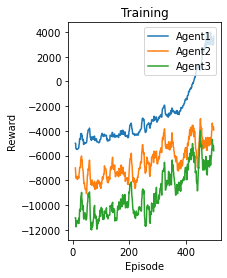

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 4000
max_episodes = 500
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    nns = [0]*env.n_agents
    nos = [0]*env.n_agents
    for i in range(env.n_agents):
        nns[i] = ActorCritic(num_inputs, num_outputs, hidden_size)
        nos[i] = optim.Adam(nns[i].parameters(), lr=3e-4)
        
#     actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
# #     if T.cuda.is_available():
# #         actor_critic.cuda()
#     ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-4)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-4)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    tot_entropies = [0]*env.n_agents
    train = True     
#     while train:
#     env.reset()
#     env.render()
#     sleep(5)
#     env.viewer.close()
    for episode in range(max_episodes):
        if not train:
            break
        all_values = [None]*env.n_agents
        all_log_probs = [None]*env.n_agents
        all_advs = [None]*env.n_agents
        
        all_qs = [None]*env.n_agents
#         all_advs = []*env.n_agents
        qs = [None]*env.n_agents
        rewards = []
        done = False
        state = env.reset()
        print(env.agents[0].y)
        print(f'\n\n\nEpisode No. {episode}')
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals < env.n_agents and steps< num_steps:
            values = [None]*env.n_agents
            policy_dists = [None]*env.n_agents
            dists = [None]*env.n_agents
            actions = [None]*env.n_agents
            log_probs = [None]*env.n_agents
            entropies = [0]*env.n_agents
#             values[0],policy_dists[0] = actor_critic1.forward(state[0])
#             values[1],policy_dists[1] = actor_critic2.forward(state[1])
            for i in range(env.n_agents):                
                values[i],policy_dists[i] = nns[i].forward(state[i])
                values[i] = values[i].detach().numpy()[0,0]
                dists[i] = policy_dists[i].detach().numpy()
                actions[i] = np.random.choice(num_outputs, p=np.squeeze(dists[i]))
                log_probs[i] = T.log(policy_dists[i].squeeze(0)[actions[i]])
                entropies[i] = -np.sum(np.mean(dists[i]) * np.log(dists[i]))

            new_state, reward, done, _ = env.step(actions,steps)

            if np.sum(done)>2:
                print('-----------------------------------------------\n\n\n\Goal reached\n\n\n--------------------------------------------------------')
            goals = np.sum(done)
            rewards.append(reward)
            for i in range(env.n_agents):
                if all_values[i] is None:
                    all_values[i] = [values[i]]
                    all_log_probs[i] = [log_probs[i]]
                else:
                    all_values[i].append(values[i])
                    all_log_probs[i].append(log_probs[i])
                tot_entropies[i] += entropies[i]
            state = new_state
            steps+=1
            if episode>=490:
                env.render()
#             sleep(0.2)
                                     # INSIDE WHILE    

        print(f'took {steps} no of steps')
#         qs[0],_ = actor_critic1.forward(new_state[0])
#         qs[1],_ = actor_critic2.forward(new_state[1])


        for i in range(env.n_agents):
            qs[i],_ = nns[i].forward(new_state[i])
            qs[i] = qs[i].detach().numpy()[0,0]
            all_qs[i] = np.zeros_like(all_values[i])
        for i in range(env.n_agents):
            for t in reversed(range(len(rewards))):
                qs[i] = rewards[t][0] + 0.99 * qs[i]
                all_qs[i][t] = qs[i]
            all_values[i] = T.FloatTensor(all_values[i])
            all_qs[i] = T.FloatTensor(all_qs[i])
            all_log_probs[i] = T.stack(all_log_probs[i])
            all_advs[i] = all_qs[i] - all_values[i]
            
        all_rewards.append(np.sum(rewards, axis = 0))
        all_lengths.append(steps)
        actor_loss = T.FloatTensor([0]*env.n_agents)
        critic_loss = T.FloatTensor([0]*env.n_agents)
        ac_loss = T.FloatTensor([0]*env.n_agents)

        advantage1 = all_advs[0]#Qvals1 - values1
        actor_loss1 =  (-all_log_probs[0] * all_advs[0]).mean() # (-log_probs1 * advantage1).mean()
        critic_loss1 = 0.5 * advantage1.pow(2).mean()
        ac_loss1 = actor_loss1 + critic_loss1 + 0.001 *  tot_entropies[0]

        nos[0].zero_grad()
        ac_loss1.backward()
        nos[0].step()

        advantage2 = all_advs[1]#Qvals2 - values2
        actor_loss2 =  (-all_log_probs[1] * all_advs[1]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 *  tot_entropies[1]

        nos[1].zero_grad()
        ac_loss2.backward()
        nos[1].step()
        
        advantage3 = all_advs[2]#Qvals2 - values2
        actor_loss3 =  (-all_log_probs[2] * all_advs[2]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss3 = 0.5 * advantage3.pow(2).mean()
        ac_loss3 = actor_loss3 + critic_loss3 + 0.001 *  tot_entropies[2]

        nos[2].zero_grad()
        ac_loss3.backward()
        nos[2].step()

#         for i in range(env.n_agents):
#             print(i)
#             actor_loss[i] = (-all_log_probs[i] * all_advs[i]).mean()
#             critic_loss[i] = 0.5 * all_advs[i].pow(2).mean()
#             ac_loss[i] = actor_loss[i] + critic_loss[i] + 0.001 * tot_entropies[i]
# #             print(type(all_log_probs[i]),all_log_probs[i])
# #             print(type(all_advs[i]),all_advs[i])
#             nos[i].zero_grad()
#             ac_loss[i].backward()
#             nos[i].step()
         
    
            
    
        # Plot results
#     print(all_rewards)
    all_rewards = np.array(all_rewards)
    smoothed_rewards = [0]*env.n_agents
    plt.subplot(121)
    for i in range(env.n_agents):
        smoothed_rewards[i] = (pd.Series.rolling(pd.Series(all_rewards[:,i]), 10).mean())
        plt.plot(smoothed_rewards[i],label = f'Agent{i+1}')
#     smoothed_rewards1 = [elem for elem in smoothed_rewards1]
#     smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    
    # plt.plot(all_rewards)

#     plt.plot(smoothed_rewards1,label = 'Agent1')
#     plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
#     eval_all_rewards = []
#     for episode in range(eval_episodes):
#         # eval_log_probs = []
#         # eval_values = []
#         eval_rewards = []
        
#         done = False
#         state = env.reset()
# #         print(type(state))
#         steps = 0
#         # for steps in range(num_steps):
#         while not done:
#             value1, policy_dist1 = actor_critic1.forward(state)
#             value1 = value1.detach().numpy()[0,0]
#             dist1 = policy_dist1.detach().numpy()

#             value2, policy_dist2 = actor_critic2.forward(state)
#             value2 = value2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

#             action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
#             # log_prob = T.log(policy_dist.squeeze(0)[action])
#             # entropy = -np.sum(np.mean(dist) * np.log(dist))
#             new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

#             eval_rewards.append(reward)
#             # eval_values.append(value)
#             # eval_log_probs.append(log_prob)
#             # entropy_term += entropy
#             state = new_state
#             steps+=1
#         eval_all_rewards.append(np.sum(eval_rewards))
#     print(eval_all_rewards)
#     # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
#     # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
#     # plt.plot(all_rewards)
#     plt.subplot(122)
#     plt.plot(eval_all_rewards)
#     plt.title('Evaluation')
#     plt.plot()
#     plt.xlabel('Eval_Episode')
#     plt.ylabel('Eval_Reward')
#     plt.tight_layout()
#     plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()





if __name__ == "__main__":
#     env = gym.make("pressureplate-linear-4p-v0")
    env = PressurePlate( 10, 6, 3, 4, 'linear')
#     print(env.observation_space)
    # print(env.observation_space.shape[0])
    # print(env.action_space.n)
    
#     print(env.reset()[0])
    
    
    a2c(env)  

## 3 Players 1st Pass

[7, 3, -1]
9



Episode No. 0
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1709 steps
9



Episode No. 1
took 4000 steps
9



Episode No. 2
took 4000 steps
9



Episode No. 3
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3702 steps
9



Episode No. 4
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3593 steps
9



Episode No. 5
took 4000 steps
9



Episode No. 6
took 4000 steps
9



Episode No. 7
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2541 steps
9



Episode No. 8
Agent reached GOAL
-----------------------------------------------


\Goal reached


-------------------------------------

9



Episode No. 60
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2706 steps
9



Episode No. 61
took 4000 steps
9



Episode No. 62
took 4000 steps
9



Episode No. 63
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3446 steps
9



Episode No. 64
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1246 steps
9



Episode No. 65
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1631 steps
9



Episode No. 66
took 4000 steps
9



Episode No. 67
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3178 steps
9


9



Episode No. 128
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 369 steps
9



Episode No. 129
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1614 steps
9



Episode No. 130
took 4000 steps
9



Episode No. 131
took 4000 steps
9



Episode No. 132
took 4000 steps
9



Episode No. 133
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1380 steps
9



Episode No. 134
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2882 steps
9



Episode No. 135
took 4000 steps
9



Episode No. 136
took 4000 steps
9



Episode No. 137
Agent reached GOAL
-----------------------------------------------


\Goal reac

took 4000 steps
9



Episode No. 197
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2514 steps
9



Episode No. 198
took 4000 steps
9



Episode No. 199
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3397 steps
9



Episode No. 200
took 4000 steps
9



Episode No. 201
took 4000 steps
9



Episode No. 202
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 712 steps
9



Episode No. 203
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3087 steps
9



Episode No. 204
took 4000 steps
9



Episode No. 205
Agent reached GOAL
-----------------------------------------------


\Goal reached


---------------

9



Episode No. 307
took 4000 steps
9



Episode No. 308
took 4000 steps
9



Episode No. 309
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3887 steps
9



Episode No. 310
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3182 steps
9



Episode No. 311
took 4000 steps
9



Episode No. 312
took 4000 steps
9



Episode No. 313
took 4000 steps
9



Episode No. 314
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2845 steps
9



Episode No. 315
took 4000 steps
9



Episode No. 316
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1062 steps
9



Episode No. 317
Agent reached GOAL
----------------------

9



Episode No. 368
took 4000 steps
9



Episode No. 369
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 818 steps
9



Episode No. 370
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1476 steps
9



Episode No. 371
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2058 steps
9



Episode No. 372
took 4000 steps
9



Episode No. 373
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1916 steps
9



Episode No. 374
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 3070 steps
9



Episode No. 375
Agent reach

9



Episode No. 420
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1637 steps
9



Episode No. 421
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1407 steps
9



Episode No. 422
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1616 steps
9



Episode No. 423
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 255 steps
9



Episode No. 424
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2755 steps
9



Episode No. 425
Agent reached GOAL
-----------------------------------------------


\Goal reached




9



Episode No. 467
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 971 steps
9



Episode No. 468
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 2787 steps
9



Episode No. 469
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 276 steps
9



Episode No. 470
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 1294 steps
9



Episode No. 471
Agent reached GOAL
-----------------------------------------------


\Goal reached


--------------------------------------------------------
took 961 steps
9



Episode No. 472
Agent reached GOAL
-----------------------------------------------


\Goal reached


--

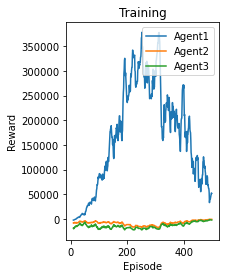

In [24]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 4000
max_episodes = 500
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    nns = [0]*env.n_agents
    nos = [0]*env.n_agents
    for i in range(env.n_agents):
        nns[i] = ActorCritic(num_inputs, num_outputs, hidden_size)
        nos[i] = optim.Adam(nns[i].parameters(), lr=3e-4)
#         nns[i] = T.load('C:/nns/model'+str(i)+'.pth')
        
        
#     actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
# #     if T.cuda.is_available():
# #         actor_critic.cuda()
#     ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-4)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-4)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    tot_entropies = [0]*env.n_agents
    train = True     
#     while train:
#     env.reset()
#     env.render()
#     sleep(5)
#     env.viewer.close()
    for episode in range(max_episodes):
        if not train:
            break
        all_values = [None]*env.n_agents
        all_log_probs = [None]*env.n_agents
        all_advs = [None]*env.n_agents
        
        all_qs = [None]*env.n_agents
#         all_advs = []*env.n_agents
        qs = [None]*env.n_agents
        rewards = []
        done = False
        state = env.reset()
        print(env.agents[0].y)
        print(f'\n\n\nEpisode No. {episode}')
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals < env.n_agents and steps< num_steps:
            values = [None]*env.n_agents
            policy_dists = [None]*env.n_agents
            dists = [None]*env.n_agents
            actions = [None]*env.n_agents
            log_probs = [None]*env.n_agents
            entropies = [0]*env.n_agents
#             values[0],policy_dists[0] = actor_critic1.forward(state[0])
#             values[1],policy_dists[1] = actor_critic2.forward(state[1])
            for i in range(env.n_agents):                
                values[i],policy_dists[i] = nns[i].forward(state[i])
                values[i] = values[i].detach().numpy()[0,0]
                dists[i] = policy_dists[i].detach().numpy()
                actions[i] = np.random.choice(num_outputs, p=np.squeeze(dists[i]))
                log_probs[i] = T.log(policy_dists[i].squeeze(0)[actions[i]])
                entropies[i] = -np.sum(np.mean(dists[i]) * np.log(dists[i]))

            new_state, reward, done, _ = env.step(actions,steps)

            if np.sum(done)>2:
                print('-----------------------------------------------\nGoal reached\n--------------------------------------------------------')
            goals = np.sum(done)
            rewards.append(reward)
            for i in range(env.n_agents):
                if all_values[i] is None:
                    all_values[i] = [values[i]]
                    all_log_probs[i] = [log_probs[i]]
                else:
                    all_values[i].append(values[i])
                    all_log_probs[i].append(log_probs[i])
                tot_entropies[i] += entropies[i]
            state = new_state
            steps+=1
            if episode>=490:
                env.render()
#             sleep(0.2)
                                     # INSIDE WHILE    

        print(f'took {steps} steps')
#         qs[0],_ = actor_critic1.forward(new_state[0])
#         qs[1],_ = actor_critic2.forward(new_state[1])


        for i in range(env.n_agents):
            qs[i],_ = nns[i].forward(new_state[i])
            qs[i] = qs[i].detach().numpy()[0,0]
            all_qs[i] = np.zeros_like(all_values[i])
        for i in range(env.n_agents):
            for t in reversed(range(len(rewards))):
                qs[i] = rewards[t][0] + 0.99 * qs[i]
                all_qs[i][t] = qs[i]
            all_values[i] = T.FloatTensor(all_values[i])
            all_qs[i] = T.FloatTensor(all_qs[i])
            all_log_probs[i] = T.stack(all_log_probs[i])
            all_advs[i] = all_qs[i] - all_values[i]
            
        all_rewards.append(np.sum(rewards, axis = 0))
        all_lengths.append(steps)
        actor_loss = T.FloatTensor([0]*env.n_agents)
        critic_loss = T.FloatTensor([0]*env.n_agents)
        ac_loss = T.FloatTensor([0]*env.n_agents)

        advantage1 = all_advs[0]#Qvals1 - values1
        actor_loss1 =  (-all_log_probs[0] * all_advs[0]).mean() # (-log_probs1 * advantage1).mean()
        critic_loss1 = 0.5 * advantage1.pow(2).mean()
        ac_loss1 = actor_loss1 + critic_loss1 + 0.001 *  tot_entropies[0]

        nos[0].zero_grad()
        ac_loss1.backward()
        nos[0].step()

        advantage2 = all_advs[1]#Qvals2 - values2
        actor_loss2 =  (-all_log_probs[1] * all_advs[1]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 *  tot_entropies[1]

        nos[1].zero_grad()
        ac_loss2.backward()
        nos[1].step()
        
        advantage3 = all_advs[2]#Qvals2 - values2
        actor_loss3 =  (-all_log_probs[2] * all_advs[2]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss3 = 0.5 * advantage3.pow(2).mean()
        ac_loss3 = actor_loss3 + critic_loss3 + 0.001 *  tot_entropies[2]

        nos[2].zero_grad()
        ac_loss3.backward()
        nos[2].step()
    for i in range(3):
        chkpt = {'state_dict': nns[i].state_dict(),'optimizer': nos[i].state_dict()}
        T.save(chkpt,'C:/nns/model'+str(i)+'.pth')

#         for i in range(env.n_agents):
#             print(i)
#             actor_loss[i] = (-all_log_probs[i] * all_advs[i]).mean()
#             critic_loss[i] = 0.5 * all_advs[i].pow(2).mean()
#             ac_loss[i] = actor_loss[i] + critic_loss[i] + 0.001 * tot_entropies[i]
# #             print(type(all_log_probs[i]),all_log_probs[i])
# #             print(type(all_advs[i]),all_advs[i])
#             nos[i].zero_grad()
#             ac_loss[i].backward()
#             nos[i].step()
         
    
            
    
        # Plot results
    
    all_rewards = np.array(all_rewards)
    print(all_rewards[-10])
    smoothed_rewards = [0]*env.n_agents
    plt.subplot(121)
    for i in range(env.n_agents):
        smoothed_rewards[i] = (pd.Series.rolling(pd.Series(all_rewards[:,i]), 10).mean())
        plt.plot(smoothed_rewards[i],label = f'Agent{i+1}')
#     smoothed_rewards1 = [elem for elem in smoothed_rewards1]
#     smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    
    # plt.plot(all_rewards)

#     plt.plot(smoothed_rewards1,label = 'Agent1')
#     plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
#     eval_all_rewards = []
#     for episode in range(eval_episodes):
#         # eval_log_probs = []
#         # eval_values = []
#         eval_rewards = []
        
#         done = False
#         state = env.reset()
# #         print(type(state))
#         steps = 0
#         # for steps in range(num_steps):
#         while not done:
#             value1, policy_dist1 = actor_critic1.forward(state)
#             value1 = value1.detach().numpy()[0,0]
#             dist1 = policy_dist1.detach().numpy()

#             value2, policy_dist2 = actor_critic2.forward(state)
#             value2 = value2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

#             action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
#             # log_prob = T.log(policy_dist.squeeze(0)[action])
#             # entropy = -np.sum(np.mean(dist) * np.log(dist))
#             new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

#             eval_rewards.append(reward)
#             # eval_values.append(value)
#             # eval_log_probs.append(log_prob)
#             # entropy_term += entropy
#             state = new_state
#             steps+=1
#         eval_all_rewards.append(np.sum(eval_rewards))
#     print(eval_all_rewards)
#     # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
#     # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
#     # plt.plot(all_rewards)
#     plt.subplot(122)
#     plt.plot(eval_all_rewards)
#     plt.title('Evaluation')
#     plt.plot()
#     plt.xlabel('Eval_Episode')
#     plt.ylabel('Eval_Reward')
#     plt.tight_layout()
#     plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()





if __name__ == "__main__":
#     env = gym.make("pressureplate-linear-4p-v0")
    env = PressurePlate( 10, 6, 3, 4, 'linear')
#     print(env.observation_space)
    # print(env.observation_space.shape[0])
    # print(env.action_space.n)
    
#     print(env.reset()[0])
    
    
    a2c(env)  

## 3 Player 2nd Pass

[7, 3, -1]
9



Episode No. 0
took 2000 steps
[3973543.   -42079.5  -29712. ]
9



Episode No. 1
took 2000 steps
[3989798.5  -42010.5  -24657. ]
9



Episode No. 2
took 2000 steps
[3959537.5  -42142.5  -29200.5]
9



Episode No. 3
took 2000 steps
[3951478.   -47130.5  -28430.5]
9



Episode No. 4
took 2000 steps
[3955532.5  -40362.   -28217.5]
9



Episode No. 5
took 2000 steps
[3633419.5  -11326.   -26785.5]
9



Episode No. 6
took 2000 steps
[3919372.   -33955.5  -26546.5]
9



Episode No. 7
took 2000 steps
[3937527.5  -38324.   -26655.5]
9



Episode No. 8
took 2000 steps
[3949580.   -44339.5  -28602.5]
9



Episode No. 9
took 2000 steps
[3987797.   -37589.5  -24655. ]
9



Episode No. 10
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 266 steps
[503786.     975.5   5967.5]
9



Episode No. 11
took 2000 steps
[3963490.5  -37097.   -26027.5]
9



Episode No. 12
Agent reached GOAL
-----------

9



Episode No. 99
took 2000 steps
[ 3.338883e+06  3.188000e+03 -1.944650e+04]
9



Episode No. 100
took 2000 steps
[3975594.   -18799.5  -17364.5]
9



Episode No. 101
took 2000 steps
[3977645.5  -30825.5  -49327.5]
9



Episode No. 102
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 164 steps
[279774.5   1168.    8023.5]
9



Episode No. 103
took 2000 steps
[3963736.5  -37606.   -21742. ]
9



Episode No. 104
took 2000 steps
[3977547.5  -39117.5  -18935. ]
9



Episode No. 105
took 2000 steps
[3905653.   -23824.5  -20394. ]
9



Episode No. 106
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 998 steps
[1.6392765e+06 1.8785000e+04 7.1250000e+02]
9



Episode No. 107
took 2000 steps
[3993898.5  -32448.   -18804. ]
9



Episode No. 108
took 2000 steps
[2928674.5   51914.5  -17883.5]
9



Episode No. 1

9



Episode No. 184
took 2000 steps
[3963638.  -25195.   -8817.]
9



Episode No. 185
took 2000 steps
[3953633.5  -30320.5   -7714.5]
9



Episode No. 186
took 2000 steps
[3973592.   -29130.    -8755.5]
9



Episode No. 187
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 718 steps
[1297574.   22795.    6546.]
9



Episode No. 188
took 2000 steps
[3971691.5  -29009.    -4333.5]
9



Episode No. 189
took 2000 steps
[3983746.5  -27489.    -6359. ]
9



Episode No. 190
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 244 steps
[447878.   2245.   9598.]
9



Episode No. 191
took 2000 steps
[3987745.5  -27437.   -18235.5]
9



Episode No. 192
took 2000 steps
[3985795.5  -29222.   -17650. ]
9



Episode No. 193
took 2000 steps
[3983695.   -31026.5   -5444. ]
9



Episode No. 194
Agent reached GOAL
----------

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 1155 steps
[2233465.5    2655.5   -5785.5]
9



Episode No. 264
took 2000 steps
[3981743.   -11916.    -7965.5]
9



Episode No. 265
took 2000 steps
[ 3.9252225e+06  6.0315000e+03 -3.3345000e+03]
9



Episode No. 266
took 2000 steps
[3947680.   -28130.5   -5985. ]
9



Episode No. 267
took 2000 steps
[3955731.5  -29520.   -12123. ]
9



Episode No. 268
took 2000 steps
[3951681.5  -29784.    -4639. ]
9



Episode No. 269
took 2000 steps
[3883349.5   11292.   -26936. ]
9



Episode No. 270
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 729 steps
[963355.5  30988.    4548.5]
9



Episode No. 271
took 2000 steps
[3967591.5  -29196.    -5238. ]
9



Episode No. 272
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------

9



Episode No. 329
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 142 steps
[271944.5  19006.    8567. ]
9



Episode No. 330
took 2000 steps
[3985697.5  -22983.5  -22255. ]
9



Episode No. 331
took 2000 steps
[3811438.   -20804.5  -12261.5]
9



Episode No. 332
took 2000 steps
[3991898.   -27602.5   -5137.5]
9



Episode No. 333
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 121 steps
[237997.5   -784.5   8686.5]
9



Episode No. 334
took 2000 steps
[3981598.5  -20950.    -6374. ]
9



Episode No. 335
took 2000 steps
[3971593.5  -29227.5   -6319. ]
9



Episode No. 336
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 120 steps
[223991.   -579.   9247.]
9



Episode No. 337
Agent reached GOAL
------------

took 2000 steps
[3969543.5  -23848.   -17421.5]
9



Episode No. 392
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 1230 steps
[2361590.    17942.5   10271.5]
9



Episode No. 393
took 2000 steps
[3977890.5   15072.5  -44863.5]
9



Episode No. 394
took 2000 steps
[3981598.5   19738.   -44853.5]
9



Episode No. 395
took 2000 steps
[ 3.973643e+06 -2.474400e+04  2.560500e+03]
9



Episode No. 396
took 2000 steps
[3967588.   -14348.5  -10756. ]
9



Episode No. 397
took 2000 steps
[ 3.9698365e+06 -1.2764000e+04 -4.5950000e+02]
9



Episode No. 398
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 1575 steps
[3121738.   -13028.5   12481.5]
9



Episode No. 399
took 2000 steps
[ 3.9654405e+06 -2.0099500e+04  4.1300000e+02]
9



Episode No. 400
took 2000 steps
[3969739.   -22430.5  -18219.5]
9



Episode No

took 2000 steps
[3953437.    -4893.5  -42938. ]
9



Episode No. 457
took 2000 steps
[3959735.   -26519.    -4016.5]
9



Episode No. 458
took 2000 steps
[3967640.5   23122.     4328. ]
9



Episode No. 459
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 80 steps
[125828.    9526.5   9226. ]
9



Episode No. 460
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 150 steps
[295997.  42948.   9125.]
9



Episode No. 461
took 2000 steps
[3987846.5  -13115.5  -42457. ]
9



Episode No. 462
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 100 steps
[183991.   20671.5   9691.5]
9



Episode No. 463
took 2000 steps
[ 3.9775475e+06  1.7935000e+03 -4.3294000e+04]
9



Episode No. 464
took 2000 steps
[3961536.5  111136.5  

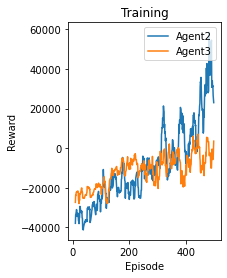

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 2000
max_episodes = 500
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    nns = [0]*env.n_agents
    nos = [0]*env.n_agents
    for i in range(env.n_agents):
        nns[i] = ActorCritic(num_inputs, num_outputs, hidden_size)
        nos[i] = optim.Adam(nns[i].parameters(), lr=3e-4)
#         checkpoint = T.load('C:/nns/model'+str(i)+'.pth')
#         nns[i].load_state_dict(checkpoint['state_dict'])
#         nos[i].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model0.pth')
    nns[0].load_state_dict(checkpoint['state_dict'])
    nos[0].load_state_dict(checkpoint['optimizer'])
        
        
        
#     actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
# #     if T.cuda.is_available():
# #         actor_critic.cuda()
#     ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-4)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-4)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    tot_entropies = [0]*env.n_agents
    train = True     
#     while train:
#     env.reset()
#     env.render()
#     sleep(5)
#     env.viewer.close()
    for episode in range(max_episodes):
        if not train:
            break
        all_values = [None]*env.n_agents
        all_log_probs = [None]*env.n_agents
        all_advs = [None]*env.n_agents
        
        all_qs = [None]*env.n_agents
#         all_advs = []*env.n_agents
        qs = [None]*env.n_agents
        rewards = []
        done = False
        state = env.reset()
        print(env.agents[0].y)
        print(f'\n\n\nEpisode No. {episode}')
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals < env.n_agents and steps< num_steps:
            values = [None]*env.n_agents
            policy_dists = [None]*env.n_agents
            dists = [None]*env.n_agents
            actions = [None]*env.n_agents
            log_probs = [None]*env.n_agents
            entropies = [0]*env.n_agents
#             values[0],policy_dists[0] = actor_critic1.forward(state[0])
#             values[1],policy_dists[1] = actor_critic2.forward(state[1])
            for i in range(env.n_agents):                
                values[i],policy_dists[i] = nns[i].forward(state[i])
                values[i] = values[i].detach().numpy()[0,0]
                dists[i] = policy_dists[i].detach().numpy()
                actions[i] = np.random.choice(num_outputs, p=np.squeeze(dists[i]))
                log_probs[i] = T.log(policy_dists[i].squeeze(0)[actions[i]])
                entropies[i] = -np.sum(np.mean(dists[i]) * np.log(dists[i]))

            new_state, reward, done, _ = env.step(actions,steps)

            if np.sum(done)>2:
                print('-----------------------------------------------\nGoal reached\n--------------------------------------------------------')
            goals = np.sum(done)
            rewards.append(reward)
            for i in range(env.n_agents):
                if all_values[i] is None:
                    all_values[i] = [values[i]]
                    all_log_probs[i] = [log_probs[i]]
                else:
                    all_values[i].append(values[i])
                    all_log_probs[i].append(log_probs[i])
                tot_entropies[i] += entropies[i]
            state = new_state
            steps+=1
            if episode>=490:
                env.render()
#             sleep(0.2)
                                     # INSIDE WHILE    

        print(f'took {steps} steps')
#         qs[0],_ = actor_critic1.forward(new_state[0])
#         qs[1],_ = actor_critic2.forward(new_state[1])


        for i in range(env.n_agents):
            qs[i],_ = nns[i].forward(new_state[i])
            qs[i] = qs[i].detach().numpy()[0,0]
            all_qs[i] = np.zeros_like(all_values[i])
        for i in range(env.n_agents):
            for t in reversed(range(len(rewards))):
                qs[i] = rewards[t][i] + 0.99 * qs[i]
                all_qs[i][t] = qs[i]
            all_values[i] = T.FloatTensor(all_values[i])
            all_qs[i] = T.FloatTensor(all_qs[i])
            all_log_probs[i] = T.stack(all_log_probs[i])
            all_advs[i] = all_qs[i] - all_values[i]
        print(np.sum(rewards, axis = 0))
        all_rewards.append(np.sum(rewards, axis = 0))
        all_lengths.append(steps)
        actor_loss = T.FloatTensor([0]*env.n_agents)
        critic_loss = T.FloatTensor([0]*env.n_agents)
        ac_loss = T.FloatTensor([0]*env.n_agents)

#         advantage1 = all_advs[0]#Qvals1 - values1
#         actor_loss1 =  (-all_log_probs[0] * all_advs[0]).mean() # (-log_probs1 * advantage1).mean()
#         critic_loss1 = 0.5 * advantage1.pow(2).mean()
#         ac_loss1 = actor_loss1 + critic_loss1 + 0.001 *  tot_entropies[0]

#         nos[0].zero_grad()
#         ac_loss1.backward()
#         nos[0].step()

        advantage2 = all_advs[1]#Qvals2 - values2
        actor_loss2 =  (-all_log_probs[1] * all_advs[1]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 *  tot_entropies[1]

        nos[1].zero_grad()
        ac_loss2.backward()
        nos[1].step()
        
        advantage3 = all_advs[2]#Qvals2 - values2
        actor_loss3 =  (-all_log_probs[2] * all_advs[2]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss3 = 0.5 * advantage3.pow(2).mean()
        ac_loss3 = actor_loss3 + critic_loss3 + 0.001 *  tot_entropies[2]

        nos[2].zero_grad()
        ac_loss3.backward()
        nos[2].step()
    for i in range(3):
        chkpt = {'state_dict': nns[i].state_dict(),'optimizer': nos[i].state_dict()}
        T.save(chkpt,'C:/nns/model'+str(i)+'.pth')

#         for i in range(env.n_agents):
#             print(i)
#             actor_loss[i] = (-all_log_probs[i] * all_advs[i]).mean()
#             critic_loss[i] = 0.5 * all_advs[i].pow(2).mean()
#             ac_loss[i] = actor_loss[i] + critic_loss[i] + 0.001 * tot_entropies[i]
# #             print(type(all_log_probs[i]),all_log_probs[i])
# #             print(type(all_advs[i]),all_advs[i])
#             nos[i].zero_grad()
#             ac_loss[i].backward()
#             nos[i].step()
         
    
            
    
        # Plot results
    
    all_rewards = np.array(all_rewards)
    print(all_rewards[-10])
    smoothed_rewards = [0]*env.n_agents
    plt.subplot(121)
    for i in range(1,env.n_agents):
        smoothed_rewards[i] = (pd.Series.rolling(pd.Series(all_rewards[:,i]), 10).mean())
        plt.plot(smoothed_rewards[i],label = f'Agent{i+1}')
#     smoothed_rewards1 = [elem for elem in smoothed_rewards1]
#     smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    
    # plt.plot(all_rewards)

#     plt.plot(smoothed_rewards1,label = 'Agent1')
#     plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
#     eval_all_rewards = []
#     for episode in range(eval_episodes):
#         # eval_log_probs = []
#         # eval_values = []
#         eval_rewards = []
        
#         done = False
#         state = env.reset()
# #         print(type(state))
#         steps = 0
#         # for steps in range(num_steps):
#         while not done:
#             value1, policy_dist1 = actor_critic1.forward(state)
#             value1 = value1.detach().numpy()[0,0]
#             dist1 = policy_dist1.detach().numpy()

#             value2, policy_dist2 = actor_critic2.forward(state)
#             value2 = value2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

#             action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
#             # log_prob = T.log(policy_dist.squeeze(0)[action])
#             # entropy = -np.sum(np.mean(dist) * np.log(dist))
#             new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

#             eval_rewards.append(reward)
#             # eval_values.append(value)
#             # eval_log_probs.append(log_prob)
#             # entropy_term += entropy
#             state = new_state
#             steps+=1
#         eval_all_rewards.append(np.sum(eval_rewards))
#     print(eval_all_rewards)
#     # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
#     # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
#     # plt.plot(all_rewards)
#     plt.subplot(122)
#     plt.plot(eval_all_rewards)
#     plt.title('Evaluation')
#     plt.plot()
#     plt.xlabel('Eval_Episode')
#     plt.ylabel('Eval_Reward')
#     plt.tight_layout()
#     plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()





if __name__ == "__main__":
#     env = gym.make("pressureplate-linear-4p-v0")
    env = PressurePlate( 10, 6, 3, 4, 'linear')
#     print(env.observation_space)
    # print(env.observation_space.shape[0])
    # print(env.action_space.n)
    
#     print(env.reset()[0])
    
    
    a2c(env)  

## 3 Player 3rd Pass

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[7, 3, -1]
9



Episode No. 0
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 76 steps
[123886.5  84162.5   8793.5]
9



Episode No. 1
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 121 steps
[231945.  171377.5   7967. ]
9



Episode No. 2
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 93 steps
[181997.5 123688.5   8844. ]
9



Episode No. 3
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 134 steps
[251892.5 189425.5   8606. ]
9



Episode No. 4
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 106 steps
[191940.  125592.   

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 93 steps
[167990.5 124077.    8170.5]
9



Episode No. 51
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 115 steps
[215992.5 163642.    8257.5]
9



Episode No. 52
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 82 steps
[157996.  119599.    8836.5]
9



Episode No. 53
took 150 steps
[271985. 225833.  -2954.]
9



Episode No. 54
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 71 steps
[117938.5  87810.    9135.5]
9



Episode No. 55
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
t

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 142 steps
[277996.5 179716.    7452. ]
9



Episode No. 100
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 133 steps
[263998.5 171775.5   8124.5]
9



Episode No. 101
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 83 steps
[159947.5 137863.5   8480. ]
9



Episode No. 102
took 150 steps
[293996.5  -2582.5  -2484. ]
9



Episode No. 103
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 70 steps
[125992.   87934.    8697.5]
9



Episode No. 104
took 150 steps
[289945.5 203783.   -2884.5]
9



Episode No. 105
Agent reached GOAL
---------------------------------------------

-----------------------------------------------
Goal reached
--------------------------------------------------------
took 120 steps
[229994.5 161877.    8283. ]
9



Episode No. 148
took 150 steps
[155796.     544.5  -2485.5]
9



Episode No. 149
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 90 steps
[167993. 127817.   8328.]
9



Episode No. 150
took 150 steps
[295997.5 259780.5  -2402. ]
9



Episode No. 151
took 150 steps
[ 53628.  229943.5  -3145.5]
9



Episode No. 152
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 72 steps
[141998.5 111863.    8844.5]
9



Episode No. 153
took 150 steps
[289945.5   -346.   -3126. ]
9



Episode No. 154
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 52 steps
[95897.

9



Episode No. 196
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 77 steps
[123968.5  92262.    9012.5]
9



Episode No. 197
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 136 steps
[263995.5 227613.5   7405. ]
9



Episode No. 198
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 91 steps
[ 97808.  137899.5   8776. ]
9



Episode No. 199
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 122 steps
[205832.  156391.    8329.5]
9



Episode No. 200
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 50 steps
[91946.  39925.5  9389

-----------------------------------------------
Goal reached
--------------------------------------------------------
took 113 steps
[217946.5 187851.5   7986.5]
9



Episode No. 239
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 104 steps
[197994.5 159974.5   8082.5]
9



Episode No. 240
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 76 steps
[145996.5 122064.5   8799.5]
9



Episode No. 241
took 150 steps
[257780.   -1333.5  -2346. ]
9



Episode No. 242
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 142 steps
[279997.5 245888.    7159. ]
9



Episode No. 243
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 84 st

[ 2.839425e+05 -5.150000e+01 -3.189000e+03]
9



Episode No. 285
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 122 steps
[221985.  140358.5   8219. ]
9



Episode No. 286
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 70 steps
[113986.5  26095.5   9413. ]
9



Episode No. 287
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 120 steps
[221891.5 154209.5   8447. ]
9



Episode No. 288
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 86 steps
[163995.5 101840.    8430. ]
9



Episode No. 289
took 150 steps
[143842.   1607.  -2032.]
9



Episode No. 290
Agent reached GOAL
-----------------------------------------------


-----------------------------------------------
Goal reached
--------------------------------------------------------
took 77 steps
[137893.5 119864.5   8739. ]
9



Episode No. 331
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 40 steps
[75948.5 49876.   9255.5]
9



Episode No. 332
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 77 steps
[79913.5 47272.5  9220. ]
9



Episode No. 333
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 106 steps
[197992.5 161997.5   8376.5]
9



Episode No. 334
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 91 steps
[161988.5 134205.    8510. ]
9



Episode No. 335
Agent reached GOAL


-----------------------------------------------
Goal reached
--------------------------------------------------------
took 60 steps
[93987.  60431.5  9194. ]
9



Episode No. 375
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 41 steps
[79998.5 45911.5  9502. ]
9



Episode No. 376
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 80 steps
[143992. 116053.   9230.]
9



Episode No. 377
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 77 steps
[141992.5  98006.    8738. ]
9



Episode No. 378
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 99 steps
[187994.5 146054.    8662. ]
9



Episode No. 379
Agent reached GOAL
----

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 69 steps
[127945.5 102056.5   8909.5]
9



Episode No. 421
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 63 steps
[109893.   78048.5   9211. ]
9



Episode No. 422
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 31 steps
[49993.5 25902.5  9686.5]
9



Episode No. 423
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 88 steps
[171948.5 156026.5   8600. ]
9



Episode No. 424
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 92 steps
[169894.5 145709.5   8714.5]
9



Episode No. 42

-----------------------------------------------
Goal reached
--------------------------------------------------------
took 75 steps
[145997.5 117709.5   8819.5]
9



Episode No. 467
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 59 steps
[115998.5  89825.    9320. ]
9



Episode No. 468
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 44 steps
[75943.  46055.5  9543.5]
9



Episode No. 469
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 38 steps
[69995.  41860.   9587.5]
9



Episode No. 470
took 150 steps
[ -203.    229.5 -2853. ]
9



Episode No. 471
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 60 steps
[105992.

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 39 steps
[71996.5 45962.   9431.5]
9



Episode No. 511
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 113 steps
[177826.5  78657.    8200. ]
9



Episode No. 512
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 60 steps
[115997.5  44040.5   9233. ]
9



Episode No. 513
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 44 steps
[81996.5 65929.5  9535. ]
9



Episode No. 514
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 80 steps
[143991.5 119841.    8981.5]
9



Episode No. 515


Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 60 steps
[101941.5  74201.    9282. ]
9



Episode No. 553
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 50 steps
[77889.  54244.5  9209.5]
9



Episode No. 554
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 38 steps
[51889.5 32441.5  9738.5]
9



Episode No. 555
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 77 steps
[123884.   96317.    9087.5]
9



Episode No. 556
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 42 steps
[75946.  60014.5  9717. ]
9



Episode No. 557
Agen

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 86 steps
[169998.5 145861.5   8680.5]
9



Episode No. 595
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 25 steps
[45997.5 25924.5  9778.5]
9



Episode No. 596
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 42 steps
[81998.5 66028.5  9269. ]
9



Episode No. 597
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 46 steps
[75991.5 58197.5  9491.5]
9



Episode No. 598
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 47 steps
[89948.  65922.   9537.5]
9



Episode No. 599
Agent r

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 59 steps
[113997.5  91872.5   9020.5]
9



Episode No. 637
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 38 steps
[49936.5 38291.5  9621. ]
9



Episode No. 638
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 34 steps
[65998.5 31820.   9704.5]
9



Episode No. 639
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 71 steps
[119938.   94058.5   9146. ]
9



Episode No. 640
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 64 steps
[123997.5  67624.    9340. ]
9



Episode No. 641
A

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 112 steps
[203940.  171852.5   7778. ]
9



Episode No. 681
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 53 steps
[83939.5 72160.   9570.5]
9



Episode No. 682
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 33 steps
[61997.5 31808.   9677.5]
9



Episode No. 683
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 63 steps
[111992.5  86014.5   9198. ]
9



Episode No. 684
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 30 steps
[53996.5 35973.5  9677.5]
9



Episode No. 685
Age

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 86 steps
[167948.5 143725.    8123.5]
9



Episode No. 723
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 32 steps
[45888. 34264.  9573.]
9



Episode No. 724
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 44 steps
[77945.5 59965.5  9232.5]
9



Episode No. 725
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 33 steps
[61948.5 43929.5  9553. ]
9



Episode No. 726
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 45 steps
[53979.5 38691.5  9198. ]
9



Episode No. 727
Agent reac

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 23 steps
[33993.5 20265.5  9785.5]
9



Episode No. 765
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 45 steps
[71990.5 52203.   9587.5]
9



Episode No. 766
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 29 steps
[49995.  20102.5  9809.5]
9



Episode No. 767
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 52 steps
[97995.5 82075.5  9424. ]
9



Episode No. 768
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 29 steps
[53997.5 32074.5  9700. ]
9



Episode No. 769
Agent reac

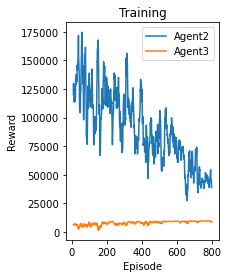

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 150
max_episodes = 800
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    nns = [0]*env.n_agents
    nos = [0]*env.n_agents
    for i in range(env.n_agents):
        nns[i] = ActorCritic(num_inputs, num_outputs, hidden_size)
        nos[i] = optim.Adam(nns[i].parameters(), lr=3e-4)
#         checkpoint = T.load('C:/nns/model'+str(i)+'.pth')
#         nns[i].load_state_dict(checkpoint['state_dict'])
#         nos[i].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model0.pth')
    nns[0].load_state_dict(checkpoint['state_dict'])
    nos[0].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model1.pth')
    nns[1].load_state_dict(checkpoint['state_dict'])
    nos[1].load_state_dict(checkpoint['optimizer'])
        
        
        
#     actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
# #     if T.cuda.is_available():
# #         actor_critic.cuda()
#     ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-4)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-4)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    tot_entropies = [0]*env.n_agents
    train = True     
#     while train:
#     env.reset()
#     env.render()
#     sleep(5)
#     env.viewer.close()
    for episode in range(max_episodes):
        if not train:
            break
        all_values = [None]*env.n_agents
        all_log_probs = [None]*env.n_agents
        all_advs = [None]*env.n_agents
        
        all_qs = [None]*env.n_agents
#         all_advs = []*env.n_agents
        qs = [None]*env.n_agents
        rewards = []
        done = False
        state = env.reset()
        print(env.agents[0].y)
        print(f'\n\n\nEpisode No. {episode}')
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals < env.n_agents and steps< num_steps:
            values = [None]*env.n_agents
            policy_dists = [None]*env.n_agents
            dists = [None]*env.n_agents
            actions = [None]*env.n_agents
            log_probs = [None]*env.n_agents
            entropies = [0]*env.n_agents
#             values[0],policy_dists[0] = actor_critic1.forward(state[0])
#             values[1],policy_dists[1] = actor_critic2.forward(state[1])
            for i in range(env.n_agents):                
                values[i],policy_dists[i] = nns[i].forward(state[i])
                values[i] = values[i].detach().numpy()[0,0]
                dists[i] = policy_dists[i].detach().numpy()
                actions[i] = np.random.choice(num_outputs, p=np.squeeze(dists[i]))
                log_probs[i] = T.log(policy_dists[i].squeeze(0)[actions[i]])
                entropies[i] = -np.sum(np.mean(dists[i]) * np.log(dists[i]))

            new_state, reward, done, _ = env.step(actions,steps)

            if np.sum(done)>2:
                print('-----------------------------------------------\nGoal reached\n--------------------------------------------------------')
            goals = np.sum(done)
            rewards.append(reward)
            for i in range(env.n_agents):
                if all_values[i] is None:
                    all_values[i] = [values[i]]
                    all_log_probs[i] = [log_probs[i]]
                else:
                    all_values[i].append(values[i])
                    all_log_probs[i].append(log_probs[i])
                tot_entropies[i] += entropies[i]
            state = new_state
            steps+=1
            if episode>=490:
                env.render()
#             sleep(0.2)
                                     # INSIDE WHILE    

        print(f'took {steps} steps')
#         qs[0],_ = actor_critic1.forward(new_state[0])
#         qs[1],_ = actor_critic2.forward(new_state[1])


        for i in range(env.n_agents):
            qs[i],_ = nns[i].forward(new_state[i])
            qs[i] = qs[i].detach().numpy()[0,0]
            all_qs[i] = np.zeros_like(all_values[i])
        for i in range(env.n_agents):
            for t in reversed(range(len(rewards))):
                qs[i] = rewards[t][i] + 0.99 * qs[i]
                all_qs[i][t] = qs[i]
            all_values[i] = T.FloatTensor(all_values[i])
            all_qs[i] = T.FloatTensor(all_qs[i])
            all_log_probs[i] = T.stack(all_log_probs[i])
            all_advs[i] = all_qs[i] - all_values[i]
        print(np.sum(rewards, axis = 0))
        all_rewards.append(np.sum(rewards, axis = 0))
        all_lengths.append(steps)
        actor_loss = T.FloatTensor([0]*env.n_agents)
        critic_loss = T.FloatTensor([0]*env.n_agents)
        ac_loss = T.FloatTensor([0]*env.n_agents)

#         advantage1 = all_advs[0]#Qvals1 - values1
#         actor_loss1 =  (-all_log_probs[0] * all_advs[0]).mean() # (-log_probs1 * advantage1).mean()
#         critic_loss1 = 0.5 * advantage1.pow(2).mean()
#         ac_loss1 = actor_loss1 + critic_loss1 + 0.001 *  tot_entropies[0]

#         nos[0].zero_grad()
#         ac_loss1.backward()
#         nos[0].step()

        advantage2 = all_advs[1]#Qvals2 - values2
        actor_loss2 =  (-all_log_probs[1] * all_advs[1]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 *  tot_entropies[1]

        nos[1].zero_grad()
        ac_loss2.backward()
        nos[1].step()
        
        advantage3 = all_advs[2]#Qvals2 - values2
        actor_loss3 =  (-all_log_probs[2] * all_advs[2]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss3 = 0.5 * advantage3.pow(2).mean()
        ac_loss3 = actor_loss3 + critic_loss3 + 0.001 *  tot_entropies[2]

        nos[2].zero_grad()
        ac_loss3.backward()
        nos[2].step()
    for i in range(3):
        chkpt = {'state_dict': nns[i].state_dict(),'optimizer': nos[i].state_dict()}
        T.save(chkpt,'C:/nns/model'+str(i)+'.pth')

#         for i in range(env.n_agents):
#             print(i)
#             actor_loss[i] = (-all_log_probs[i] * all_advs[i]).mean()
#             critic_loss[i] = 0.5 * all_advs[i].pow(2).mean()
#             ac_loss[i] = actor_loss[i] + critic_loss[i] + 0.001 * tot_entropies[i]
# #             print(type(all_log_probs[i]),all_log_probs[i])
# #             print(type(all_advs[i]),all_advs[i])
#             nos[i].zero_grad()
#             ac_loss[i].backward()
#             nos[i].step()
         
    
            
    
        # Plot results
    
    all_rewards = np.array(all_rewards)
    print(all_rewards[-10])
    smoothed_rewards = [0]*env.n_agents
    plt.subplot(121)
    for i in range(0,env.n_agents):
        smoothed_rewards[i] = (pd.Series.rolling(pd.Series(all_rewards[:,i]), 10).mean())
        plt.plot(smoothed_rewards[i],label = f'Agent{i+1}')
#     smoothed_rewards1 = [elem for elem in smoothed_rewards1]
#     smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    
    # plt.plot(all_rewards)

#     plt.plot(smoothed_rewards1,label = 'Agent1')
#     plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
#     eval_all_rewards = []
#     for episode in range(eval_episodes):
#         # eval_log_probs = []
#         # eval_values = []
#         eval_rewards = []
        
#         done = False
#         state = env.reset()
# #         print(type(state))
#         steps = 0
#         # for steps in range(num_steps):
#         while not done:
#             value1, policy_dist1 = actor_critic1.forward(state)
#             value1 = value1.detach().numpy()[0,0]
#             dist1 = policy_dist1.detach().numpy()

#             value2, policy_dist2 = actor_critic2.forward(state)
#             value2 = value2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

#             action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
#             # log_prob = T.log(policy_dist.squeeze(0)[action])
#             # entropy = -np.sum(np.mean(dist) * np.log(dist))
#             new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

#             eval_rewards.append(reward)
#             # eval_values.append(value)
#             # eval_log_probs.append(log_prob)
#             # entropy_term += entropy
#             state = new_state
#             steps+=1
#         eval_all_rewards.append(np.sum(eval_rewards))
#     print(eval_all_rewards)
#     # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
#     # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
#     # plt.plot(all_rewards)
#     plt.subplot(122)
#     plt.plot(eval_all_rewards)
#     plt.title('Evaluation')
#     plt.plot()
#     plt.xlabel('Eval_Episode')
#     plt.ylabel('Eval_Reward')
#     plt.tight_layout()
#     plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()





if __name__ == "__main__":
#     env = gym.make("pressureplate-linear-4p-v0")
    env = PressurePlate( 10, 6, 3, 4, 'linear')
#     print(env.observation_space)
    # print(env.observation_space.shape[0])
    # print(env.action_space.n)
    
#     print(env.reset()[0])
    
    
    a2c(env)  

## 3 Player 4th Pass

[7, 3, -1]
9



Episode No. 0
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9958.5]
9



Episode No. 1
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9982.   9963.5]
9



Episode No. 2
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 12033.   9955. ]
9



Episode No. 3
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5 14033.   9941.5]
9



Episode No. 4
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 12033.   9955. ]
9



Epis

[23998.5 12033.   9913. ]
9



Episode No. 49
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 50
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 16 steps
[29998.5 13979.   9942.5]
9



Episode No. 51
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 15 steps
[27998.5 17986.   9959. ]
9



Episode No. 52
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5 12032.   9946. ]
9



Episode No. 53
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 12033.

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5 14033.   9940. ]
9



Episode No. 98
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5  9982.5  9955. ]
9



Episode No. 99
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 18 steps
[33998.5 22033.   9919. ]
9



Episode No. 100
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 12033.   9950. ]
9



Episode No. 101
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9964. ]
9



Episode No. 102
Agent reache

-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9936.   9958.5]
9



Episode No. 145
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[21995.  10030.5  9907. ]
9



Episode No. 146
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9964. ]
9



Episode No. 147
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5 14033.   9946. ]
9



Episode No. 148
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9984.5 10016. ]
9



Episode No. 149
Agent reached GOAL
----------

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 10030.5 10006.5]
9



Episode No. 189
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 11986.   9958.5]
9



Episode No. 190
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5 14033.   9940. ]
9



Episode No. 191
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5  7882.  10060. ]
9



Episode No. 192
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9964. ]
9



Episode No. 193
Agent reac

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5  9885.  10064. ]
9



Episode No. 239
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 15 steps
[27998.5  9928.5 10056. ]
9



Episode No. 240
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 15 steps
[27998.5 16033.   9951. ]
9



Episode No. 241
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[19997.5 10033.   9958.5]
9



Episode No. 242
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5  9883.  10112. ]
9



Episode No. 243
Agent reac

[27998.5 14032.  10008.5]
9



Episode No. 288
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[21997.5 10080.   9960. ]
9



Episode No. 289
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 15 steps
[25997.5 10028.  10056. ]
9



Episode No. 290
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 11986.   9959. ]
9



Episode No. 291
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 292
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  




Episode No. 339
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9964. ]
9



Episode No. 340
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5  9932.  10060. ]
9



Episode No. 341
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 342
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 343
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 11935.5  9960.5]
9



Episode

Episode No. 382
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5 10016. ]
9



Episode No. 383
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 384
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5  9960.5]
9



Episode No. 385
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5  9934.5 10006.5]
9



Episode No. 386
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5  9972.  10064. ]
9



Episode No

9



Episode No. 433
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5 10016. ]
9



Episode No. 434
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5 10016. ]
9



Episode No. 435
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5 10016. ]
9



Episode No. 436
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 437
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 17 steps
[31998.5 15884.  10002.5]
9



Episo

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5 15986.   9954.5]
9



Episode No. 476
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 477
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9982.5  9964. ]
9



Episode No. 478
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 479
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 11986.   9960.5]
9



Episode No. 480
Agent reac

-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5  9933.5 10008.5]
9



Episode No. 521
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 522
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5  9934.  10064. ]
9



Episode No. 523
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9979.  10016. ]
9



Episode No. 524
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  7935.  10016. ]
9



Episode No. 525
Agent reached GOAL
----------

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 570
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5 10016. ]
9



Episode No. 571
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  7936.   9968. ]
9



Episode No. 572
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 573
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 574
Agent reac

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 13986.   9958.5]
9



Episode No. 621
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 622
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 13986.   9949. ]
9



Episode No. 623
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 624
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 10026.  10012. ]
9



Episode No. 625
Agent reac

Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 81 steps
[159998.5   6818.   13228. ]
9



Episode No. 670
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 671
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 672
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 11986.   9958.5]
9



Episode No. 673
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9935.5 10016. ]
9



Episode No. 674
Agent r

took 100 steps
[197998.5  -4639.    4233. ]
9



Episode No. 718
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 719
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 720
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 13 steps
[23998.5 12033.   9956.5]
9



Episode No. 721
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5  9982.5  9964. ]
9



Episode No. 722
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 1




Episode No. 765
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9964. ]
9



Episode No. 766
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9958.5]
9



Episode No. 767
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 14 steps
[25998.5  9981.  10060. ]
9



Episode No. 768
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 10033.   9964. ]
9



Episode No. 769
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode

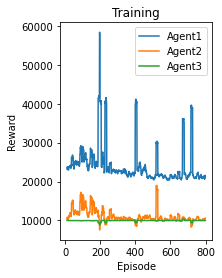

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 100
max_episodes = 800
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    nns = [0]*env.n_agents
    nos = [0]*env.n_agents
    for i in range(env.n_agents):
        nns[i] = ActorCritic(num_inputs, num_outputs, hidden_size)
        nos[i] = optim.Adam(nns[i].parameters(), lr=3e-4)
#         checkpoint = T.load('C:/nns/model'+str(i)+'.pth')
#         nns[i].load_state_dict(checkpoint['state_dict'])
#         nos[i].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model0.pth')
    nns[0].load_state_dict(checkpoint['state_dict'])
    nos[0].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model1.pth')
    nns[1].load_state_dict(checkpoint['state_dict'])
#     print(checkpoint['optimizer'])
#     print(nos[1].state_dict())
    nos[1].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model2.pth')
    nns[2].load_state_dict(checkpoint['state_dict'])
    nos[2].load_state_dict(checkpoint['optimizer'])
        
        
        
#     actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
# #     if T.cuda.is_available():
# #         actor_critic.cuda()
#     ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-4)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-4)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    tot_entropies = [0]*env.n_agents
    train = True     
#     while train:
#     env.reset()
#     env.render()
#     sleep(5)
#     env.viewer.close()
    for episode in range(max_episodes):
        if not train:
            break
        all_values = [None]*env.n_agents
        all_log_probs = [None]*env.n_agents
        all_advs = [None]*env.n_agents
        
        all_qs = [None]*env.n_agents
#         all_advs = []*env.n_agents
        qs = [None]*env.n_agents
        rewards = []
        done = False
        state = env.reset()
        print(env.agents[0].y)
        print(f'\n\n\nEpisode No. {episode}')
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals < env.n_agents and steps< num_steps:
            values = [None]*env.n_agents
            policy_dists = [None]*env.n_agents
            dists = [None]*env.n_agents
            actions = [None]*env.n_agents
            log_probs = [None]*env.n_agents
            entropies = [0]*env.n_agents
#             values[0],policy_dists[0] = actor_critic1.forward(state[0])
#             values[1],policy_dists[1] = actor_critic2.forward(state[1])
            for i in range(env.n_agents):                
                values[i],policy_dists[i] = nns[i].forward(state[i])
                values[i] = values[i].detach().numpy()[0,0]
                dists[i] = policy_dists[i].detach().numpy()
                actions[i] = np.random.choice(num_outputs, p=np.squeeze(dists[i]))
                log_probs[i] = T.log(policy_dists[i].squeeze(0)[actions[i]])
                entropies[i] = -np.sum(np.mean(dists[i]) * np.log(dists[i]))

            new_state, reward, done, _ = env.step(actions,steps)

            if np.sum(done)>2:
                print('-----------------------------------------------\nGoal reached\n--------------------------------------------------------')
            goals = np.sum(done)
            rewards.append(reward)
            for i in range(env.n_agents):
                if all_values[i] is None:
                    all_values[i] = [values[i]]
                    all_log_probs[i] = [log_probs[i]]
                else:
                    all_values[i].append(values[i])
                    all_log_probs[i].append(log_probs[i])
                tot_entropies[i] += entropies[i]
            state = new_state
            steps+=1
#             if episode>=700:
#                 env.render()
#             sleep(0.2)
                                     # INSIDE WHILE    

        print(f'took {steps} steps')
#         qs[0],_ = actor_critic1.forward(new_state[0])
#         qs[1],_ = actor_critic2.forward(new_state[1])


        for i in range(env.n_agents):
            qs[i],_ = nns[i].forward(new_state[i])
            qs[i] = qs[i].detach().numpy()[0,0]
            all_qs[i] = np.zeros_like(all_values[i])
        for i in range(env.n_agents):
            for t in reversed(range(len(rewards))):
                qs[i] = rewards[t][i] + 0.99 * qs[i]
                all_qs[i][t] = qs[i]
            all_values[i] = T.FloatTensor(all_values[i])
            all_qs[i] = T.FloatTensor(all_qs[i])
            all_log_probs[i] = T.stack(all_log_probs[i])
            all_advs[i] = all_qs[i] - all_values[i]
        print(np.sum(rewards, axis = 0))
        all_rewards.append(np.sum(rewards, axis = 0))
        all_lengths.append(steps)
        actor_loss = T.FloatTensor([0]*env.n_agents)
        critic_loss = T.FloatTensor([0]*env.n_agents)
        ac_loss = T.FloatTensor([0]*env.n_agents)

        advantage1 = all_advs[0]#Qvals1 - values1
        actor_loss1 =  (-all_log_probs[0] * all_advs[0]).mean() # (-log_probs1 * advantage1).mean()
        critic_loss1 = 0.5 * advantage1.pow(2).mean()
        ac_loss1 = actor_loss1 + critic_loss1 + 0.001 *  tot_entropies[0]

        nos[0].zero_grad()
        ac_loss1.backward()
        nos[0].step()

        advantage2 = all_advs[1]#Qvals2 - values2
        actor_loss2 =  (-all_log_probs[1] * all_advs[1]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss2 = 0.5 * advantage2.pow(2).mean()
        ac_loss2 = actor_loss2 + critic_loss2 + 0.001 *  tot_entropies[1]

        nos[1].zero_grad()
        ac_loss2.backward()
        nos[1].step()
        
        advantage3 = all_advs[2]#Qvals2 - values2
        actor_loss3 =  (-all_log_probs[2] * all_advs[2]).mean() #(-log_probs2 * advantage2).mean()
        critic_loss3 = 0.5 * advantage3.pow(2).mean()
        ac_loss3 = actor_loss3 + critic_loss3 + 0.001 *  tot_entropies[2]

        nos[2].zero_grad()
        ac_loss3.backward()
        nos[2].step()
    for i in range(3):
        chkpt = {'state_dict': nns[i].state_dict(),'optimizer': nos[i].state_dict()}
#         print(chkpt)
        T.save(chkpt,'C:/nns/model'+str(i)+'.pth')

#         for i in range(env.n_agents):
#             print(i)
#             actor_loss[i] = (-all_log_probs[i] * all_advs[i]).mean()
#             critic_loss[i] = 0.5 * all_advs[i].pow(2).mean()
#             ac_loss[i] = actor_loss[i] + critic_loss[i] + 0.001 * tot_entropies[i]
# #             print(type(all_log_probs[i]),all_log_probs[i])
# #             print(type(all_advs[i]),all_advs[i])
#             nos[i].zero_grad()
#             ac_loss[i].backward()
#             nos[i].step()
         
    
            
    
        # Plot results
    
    all_rewards = np.array(all_rewards)
    print(all_rewards[-10])
    smoothed_rewards = [0]*env.n_agents
    plt.subplot(121)
    for i in range(0,env.n_agents):
        smoothed_rewards[i] = (pd.Series.rolling(pd.Series(all_rewards[:,i]), 10).mean())
        plt.plot(smoothed_rewards[i],label = f'Agent{i+1}')
#     smoothed_rewards1 = [elem for elem in smoothed_rewards1]
#     smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    
    # plt.plot(all_rewards)

#     plt.plot(smoothed_rewards1,label = 'Agent1')
#     plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
#     eval_all_rewards = []
#     for episode in range(eval_episodes):
#         # eval_log_probs = []
#         # eval_values = []
#         eval_rewards = []
        
#         done = False
#         state = env.reset()
# #         print(type(state))
#         steps = 0
#         # for steps in range(num_steps):
#         while not done:
#             value1, policy_dist1 = actor_critic1.forward(state)
#             value1 = value1.detach().numpy()[0,0]
#             dist1 = policy_dist1.detach().numpy()

#             value2, policy_dist2 = actor_critic2.forward(state)
#             value2 = value2.detach().numpy()[0,0]
#             dist2 = policy_dist2.detach().numpy()

#             action1 = np.random.choice(num_outputs, p=np.squeeze(dist1))
#             action2 = np.random.choice(num_outputs, p=np.squeeze(dist2))
#             # log_prob = T.log(policy_dist.squeeze(0)[action])
#             # entropy = -np.sum(np.mean(dist) * np.log(dist))
#             new_state, reward, done, goal = env.step(action1, action2, deterministic = True)

#             eval_rewards.append(reward)
#             # eval_values.append(value)
#             # eval_log_probs.append(log_prob)
#             # entropy_term += entropy
#             state = new_state
#             steps+=1
#         eval_all_rewards.append(np.sum(eval_rewards))
#     print(eval_all_rewards)
#     # eval_smoothed_rewards = pd.Series.rolling(pd.Series(eval_all_rewards), 10).mean()
#     # eval_smoothed_rewards = [elem for elem in eval_smoothed_rewards]
#     # plt.plot(all_rewards)
#     plt.subplot(122)
#     plt.plot(eval_all_rewards)
#     plt.title('Evaluation')
#     plt.plot()
#     plt.xlabel('Eval_Episode')
#     plt.ylabel('Eval_Reward')
#     plt.tight_layout()
#     plt.show()
    
        # plt.plot(all_lengths)
        # plt.plot(average_lengths)
        # plt.xlabel('Episode')
        # plt.ylabel('Episode length')
        # plt.show()





if __name__ == "__main__":
#     env = gym.make("pressureplate-linear-4p-v0")
    env = PressurePlate( 10, 6, 3, 4, 'linear')
#     print(env.observation_space)
    # print(env.observation_space.shape[0])
    # print(env.action_space.n)
    
#     print(env.reset()[0])
    
    
    a2c(env)  

## Evaluation

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[7, 3, -1]
9



Episode No. 0
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 1
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 2
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 12 steps
[21998.5 11986.   9959. ]
9



Episode No. 3
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Episode No. 4
Agent reached GOAL
-----------------------------------------------
Goal reached
--------------------------------------------------------
took 11 steps
[19998.5  9986.   9968. ]
9



Epis

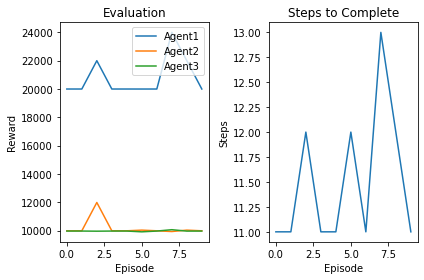

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:10:44 2022

@author: sabdu
"""


#####################################    AI BLOCK         #######################
"""I certify that the code and data in this assignment were generated independently, 
   using only the tools and resources defined in the course and that I did not receive 
   any external help, coaching or contributions during the production of this work.
"""

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep





hidden_size = 128
num_steps = 100
max_episodes = 10
eval_episodes = 10

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 64)
        self.critic_linear3 = nn.Linear(64, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 64)
        self.actor_linear3 = nn.Linear(64, num_actions)
        
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
    
    def forward(self, state):
        state = T.from_numpy(state).float().unsqueeze(0)
#         state = state.unsqueeze(0)
#         state.to(self.device)
        # print(state)
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return value, policy_dist

    # def forward(self, state):
        
    #     x = F.relu(self.fc1(state))
    #     x = F.relu(self.fc2(x))
    #     actions = self.fc3(x)

    #     return actions
    



def a2c(env):
    num_inputs = 102
    num_outputs = 5
    nns = [0]*env.n_agents
    nos = [0]*env.n_agents
    for i in range(env.n_agents):
        nns[i] = ActorCritic(num_inputs, num_outputs, hidden_size)
        nos[i] = optim.Adam(nns[i].parameters(), lr=3e-4)
#         checkpoint = T.load('C:/nns/model'+str(i)+'.pth')
#         nns[i].load_state_dict(checkpoint['state_dict'])
#         nos[i].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model0.pth')
    nns[0].load_state_dict(checkpoint['state_dict'])
    nos[0].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model1.pth')
    nns[1].load_state_dict(checkpoint['state_dict'])
    nos[1].load_state_dict(checkpoint['optimizer'])
    checkpoint = T.load('C:/nns/model2.pth')
    nns[2].load_state_dict(checkpoint['state_dict'])
    nos[2].load_state_dict(checkpoint['optimizer'])
        
        
        
#     actor_critic1 = ActorCritic(num_inputs, num_outputs, hidden_size)
#     actor_critic2 = ActorCritic(num_inputs, num_outputs, hidden_size)
# #     if T.cuda.is_available():
# #         actor_critic.cuda()
#     ac_optimizer1 = optim.Adam(actor_critic1.parameters(), lr=3e-4)
#     ac_optimizer2 = optim.Adam(actor_critic2.parameters(), lr=3e-4)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term1 = 0
    entropy_term2 = 0
    tot_entropies = [0]*env.n_agents
    train = True     
    step_progression = []
#     while train:
#     env.reset()
#     env.render()
#     sleep(5)
#     env.viewer.close()
    for episode in range(max_episodes):
        all_values = [None]*env.n_agents
        all_log_probs = [None]*env.n_agents
        all_advs = [None]*env.n_agents  
        all_qs = [None]*env.n_agents
        qs = [None]*env.n_agents
        rewards = []
        done = False
        state = env.reset()
        print(env.agents[0].y)
        print(f'\n\n\nEpisode No. {episode}')
        steps = 0
        goals = 0
        # for steps in range(num_steps):
        while goals < env.n_agents and steps< num_steps:
            values = [None]*env.n_agents
            policy_dists = [None]*env.n_agents
            dists = [None]*env.n_agents
            actions = [None]*env.n_agents
            log_probs = [None]*env.n_agents
            entropies = [0]*env.n_agents
#             values[0],policy_dists[0] = actor_critic1.forward(state[0])
#             values[1],policy_dists[1] = actor_critic2.forward(state[1])
            for i in range(env.n_agents):                
                values[i],policy_dists[i] = nns[i].forward(state[i])
                values[i] = values[i].detach().numpy()[0,0]
                dists[i] = policy_dists[i].detach().numpy()
                actions[i] = np.random.choice(num_outputs, p=np.squeeze(dists[i]))
                log_probs[i] = T.log(policy_dists[i].squeeze(0)[actions[i]])
                entropies[i] = -np.sum(np.mean(dists[i]) * np.log(dists[i]))

            new_state, reward, done, _ = env.step(actions,steps)

            if np.sum(done)>2:
                print('-----------------------------------------------\nGoal reached\n--------------------------------------------------------')
            goals = np.sum(done)
            rewards.append(reward)
            for i in range(env.n_agents):
                if all_values[i] is None:
                    all_values[i] = [values[i]]
                    all_log_probs[i] = [log_probs[i]]
                else:
                    all_values[i].append(values[i])
                    all_log_probs[i].append(log_probs[i])
                tot_entropies[i] += entropies[i]
            state = new_state
            steps+=1
#             if episode>=490:
            env.render()
            sleep(0.1)
                                     # INSIDE WHILE    

        print(f'took {steps} steps')

        print(np.sum(rewards, axis = 0))
        all_rewards.append(np.sum(rewards, axis = 0))
        step_progression.append(steps)

    
            
    
        # Plot results
    
    all_rewards = np.array(all_rewards)
    print(all_rewards)
#     smoothed_rewards = [0]*env.n_agents
    plt.subplot(121)
    for i in range(env.n_agents):
#         r1 = all_rewards[:,0]
#         r2 = all_rewards[:,1]
#         r3 = all_rewards[:,2]
#         smoothed_rewards[i] = (pd.Series.rolling(pd.Series(all_rewards[:,i]), 10).mean())
        plt.plot(all_rewards[:,i],label = f'Agent{i+1}')
#     smoothed_rewards1 = [elem for elem in smoothed_rewards1]
#     smoothed_rewards2 = [elem for elem in smoothed_rewards2]
    
    # plt.plot(all_rewards)

#     plt.plot(smoothed_rewards1,label = 'Agent1')
#     plt.plot(smoothed_rewards2,label = 'Agent2')
    plt.legend(loc='upper right')
    plt.title('Evaluation')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.subplot(122)
    plt.plot(step_progression)
    plt.title('Steps to Complete')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.tight_layout()
    plt.show()
    plt.show()
    






if __name__ == "__main__":
    env = PressurePlate( 10, 6, 3, 4, 'linear')
    a2c(env)  

In [2]:
# # nns = ActorCritic(4, 4, hidden_size)
# # nos = optim.Adam(nns.parameters(), lr=3e-4)
# # chkpt = {'state_dict': nns.state_dict(),'optimizer': nos.state_dict()}
# # T.save(chkpt,'C:/nns/modeltest.pth')
# # checkpoint = T.load('C:/nns/modeltest.pth')
# # nns.load_state_dict(checkpoint['state_dict'])
# # nos.load_state_dict(checkpoint['optimizer'])

# # print(list(range(10)))
# checkpoint = T.load('C:/nns/Latest_Pass/model1.pth')
# #     nos.load_state_dict(checkpoint['state_dict'])
# print(checkpoint['optimizer'])
#     print(nos[1].state_dict())

env = PressurePlate( 10, 6, 3, 4, 'linear')
env.reset()
env.render()

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[7, 3, -1]


True